## **NYC Taxi Demand Forecasting** ##

**Institution:** The University of Western Ontario  
**Course:** AISE 4010A - Deep Learning for Time Series Data  
**Instructor:** Soodeh Nikan

**Group Members:**
* Ahmed El Shareif - 251199128
* Evan Kale Romano - 251327329
* Joseph Dominique Toma - 251283541
* Mohammed Alamen Qassab - 251285296

Our project is going to use the 2023 NYC Yellow Taxi Trip dataset to forecast taxi demand across different zones and times in New York City. The dataset comprises over 38 million trips, including details such as pickup and drop-off timestamps, locations, distances, passenger counts, and fares. By applying deep learning models, we aim to capture demand patterns and predict future ride volumes. 

## **Sample Data Exploration & Modelling** ##

### **Data Import and Initial Setup** ###

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import requests
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
# NYC Open Data API configuration for 2023 Yellow Taxi data
# Using SODA2 API with CSV format
import_url = "https://data.cityofnewyork.us/resource/4b4i-vvec.csv"

# Load sample 
sample_size = 500000  
api_url = f"{import_url}?$limit={sample_size}"

df_sample = pd.read_csv(api_url)
print(f"Loaded sample: {df_sample.shape[0]:,} rows, {df_sample.shape[1]} columns")
print(f"Memory usage: {df_sample.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display basic information about the dataset
print("\nColumn names and types:")
print(df_sample.dtypes)

# Check date range in the loaded data
df_sample['tpep_pickup_datetime'] = pd.to_datetime(df_sample['tpep_pickup_datetime'])
print(f"\nDate range in sample:")
print(f"From: {df_sample['tpep_pickup_datetime'].min()}")
print(f"To: {df_sample['tpep_pickup_datetime'].max()}")
print(f"Number of unique days: {df_sample['tpep_pickup_datetime'].dt.date.nunique()}")

Loaded sample: 500,000 rows, 19 columns
Memory usage: 153.5 MB

Column names and types:
vendorid                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
ratecodeid               float64
store_and_fwd_flag        object
pulocationid               int64
dolocationid               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
airport_fee              float64
dtype: object

Date range in sample:
From: 2008-12-31 23:04:41
To: 2023-01-07 03:40:12
Number of unique days: 11

Date range in sample:
From: 2008-12-31 23:04:41
To: 2023-01-07 03:40:12
Number of unique days: 11


### **Data Preprocessing and Column Selection** ###

In [3]:
# Define columns relevant for demand forecasting
relevant_columns = [
    'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
    'passenger_count', 'trip_distance', 
    'pulocationid', 'dolocationid', 'fare_amount'
]

# Columns to remove which are not needed for demand prediction
columns_to_drop = [
    'vendorid', 'ratecodeid', 'store_and_fwd_flag', 
    'payment_type', 'extra', 'mta_tax', 'tip_amount',
    'tolls_amount', 'improvement_surcharge', 'total_amount',
    'congestion_surcharge', 'airport_fee'
]

# Select only relevant columns
df_clean = df_sample[relevant_columns].copy()

# Display first few rows and basic statistics
print("Selected columns for analysis:")
print(df_clean.columns.tolist())
print(f"\nDataset shape after column selection: {df_clean.shape}")
df_clean.head()

Selected columns for analysis:
['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pulocationid', 'dolocationid', 'fare_amount']

Dataset shape after column selection: (500000, 7)


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pulocationid,dolocationid,fare_amount
0,2023-01-01 00:32:10,2023-01-01T00:40:36.000,1.0,0.97,161,141,9.3
1,2023-01-01 00:55:08,2023-01-01T01:01:27.000,1.0,1.10,43,237,7.9
2,2023-01-01 00:25:04,2023-01-01T00:37:49.000,1.0,2.51,48,238,14.9
3,2023-01-01 00:03:48,2023-01-01T00:13:25.000,0.0,1.90,138,7,12.1
4,2023-01-01 00:10:29,2023-01-01T00:21:19.000,1.0,1.43,107,79,11.4


In [4]:
# Convert datetime columns 
df_clean['tpep_pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'])
df_clean['tpep_dropoff_datetime'] = pd.to_datetime(df_clean['tpep_dropoff_datetime'])

# Remove records with missing essential data
initial_count = len(df_clean)
df_clean = df_clean.dropna(subset=['tpep_pickup_datetime', 'pulocationid'])

# Filter out invalid trip distances and passenger counts
df_clean = df_clean[
    (df_clean['trip_distance'] > 0) & # Remove zero or negative distances
    (df_clean['trip_distance'] < 500) &  # Remove unrealistically long trips
    (df_clean['passenger_count'] > 0) & # Remove zero or negative passenger counts
    (df_clean['passenger_count'] <= 6)  # Remove unrealistic high passenger counts
]

# Calculate trip duration in minutes
df_clean['trip_duration_minutes'] = (
    df_clean['tpep_dropoff_datetime'] - df_clean['tpep_pickup_datetime']
).dt.total_seconds() / 60

# Remove trips with unrealistic durations
df_clean = df_clean[
    (df_clean['trip_duration_minutes'] > 1) & # Minimum 1 minute
    (df_clean['trip_duration_minutes'] < 300)  # Maximum 5 hours
]

# Display cleaning results
print(f"Data cleaning results:")
print(f"Initial records: {initial_count:,}")
print(f"After cleaning: {len(df_clean):,}")
print(f"Records removed: {initial_count - len(df_clean):,} ({(initial_count - len(df_clean))/initial_count*100:.1f}%)")

# Basic statistics of cleaned data
print(f"\nCleaned dataset summary:")
df_clean.describe()

Data cleaning results:
Initial records: 500,000
After cleaning: 482,172
Records removed: 17,828 (3.6%)

Cleaned dataset summary:

Initial records: 500,000
After cleaning: 482,172
Records removed: 17,828 (3.6%)

Cleaned dataset summary:


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pulocationid,dolocationid,fare_amount,trip_duration_minutes
count,482172,482172,482172.000000,482172.000000,482172.000000,482172.00000,482172.000000,482172.000000
mean,2023-01-04 06:41:07.625010688,2023-01-04 06:56:01.516682496,1.434936,3.818337,165.693033,163.40852,19.476645,14.898195
min,2022-10-25 00:42:10,2022-10-25 00:44:22,1.000000,0.010000,1.000000,1.00000,-497.900000,1.016667
25%,2023-01-02 19:45:38.750000128,2023-01-02 20:00:11.500000,1.000000,1.110000,132.000000,113.00000,8.600000,7.233333
50%,2023-01-04 12:26:54,2023-01-04 12:41:55,1.000000,1.900000,161.000000,162.00000,12.800000,11.716667
75%,2023-01-05 17:14:46.500000,2023-01-05 17:30:51.750000128,2.000000,3.770000,234.000000,234.00000,21.200000,18.766667
max,2023-01-07 03:40:12,2023-01-07 03:58:11,6.000000,140.020000,265.000000,265.00000,656.800000,294.166667
std,NaN,NaN,0.926320,4.899777,63.748155,70.55566,18.930847,11.507902


### **Feature Engineering for Time Series Analysis** ###

In [5]:
# Create time-based features for demand forecasting
df_clean['pickup_hour'] = df_clean['tpep_pickup_datetime'].dt.floor('H') # Round down to the nearest hour
df_clean['hour_of_day'] = df_clean['tpep_pickup_datetime'].dt.hour # Hour of the day (24-hour format)
df_clean['day_of_week'] = df_clean['tpep_pickup_datetime'].dt.dayofweek # 0=Monday, 6=Sunday
df_clean['day_name'] = df_clean['tpep_pickup_datetime'].dt.day_name() 
df_clean['month'] = df_clean['tpep_pickup_datetime'].dt.month # Month of the year
df_clean['is_weekend'] = df_clean['day_of_week'].isin([5, 6]) # True if weekend

# Create demand aggregation - trips per hour per pickup location
demand_hourly = df_clean.groupby(['pickup_hour', 'pulocationid']).agg({
    'tpep_pickup_datetime': 'count',  # Trip count
    'passenger_count': 'sum',         # Total passengers
    'trip_distance': 'mean',          # Average trip distance
    'fare_amount': 'mean',            # Average fare
    'trip_duration_minutes': 'mean',  # Average duration
}).reset_index()

# Rename columns for clarity
demand_hourly.columns = [
    'pickup_hour', 'location_id', 'trip_count', 
    'total_passengers', 'avg_trip_distance', 
    'avg_fare', 'avg_duration_minutes'
]

# Add time features to aggregated data
demand_hourly['hour_of_day'] = demand_hourly['pickup_hour'].dt.hour
demand_hourly['day_of_week'] = demand_hourly['pickup_hour'].dt.dayofweek
demand_hourly['is_weekend'] = demand_hourly['day_of_week'].isin([5, 6])

print(f"Hourly demand aggregation complete:")
print(f"Time range: {demand_hourly['pickup_hour'].min()} to {demand_hourly['pickup_hour'].max()}")
print(f"Number of unique locations: {demand_hourly['location_id'].nunique()}")
print(f"Number of hourly records: {len(demand_hourly):,}")

demand_hourly.head()

Hourly demand aggregation complete:
Time range: 2022-10-25 00:00:00 to 2023-01-07 03:00:00
Number of unique locations: 242
Number of hourly records: 12,540


,pickup_hour,location_id,trip_count,total_passengers,avg_trip_distance,avg_fare,avg_duration_minutes,hour_of_day,day_of_week,is_weekend
0,2022-10-25 00:00:00,132,1,1.0,0.97,4.5,2.200000,0,1,False
1,2022-10-25 00:00:00,265,1,1.0,2.33,10.0,10.000000,0,1,False
2,2022-10-25 09:00:00,132,1,1.0,6.48,19.5,15.216667,9,1,False
3,2022-12-31 14:00:00,48,1,1.0,0.41,10.0,10.516667,14,5,True
4,2022-12-31 14:00:00,163,1,1.0,0.54,5.8,3.900000,14,5,True


### **Preliminary Data Analysis and Visualization** ###

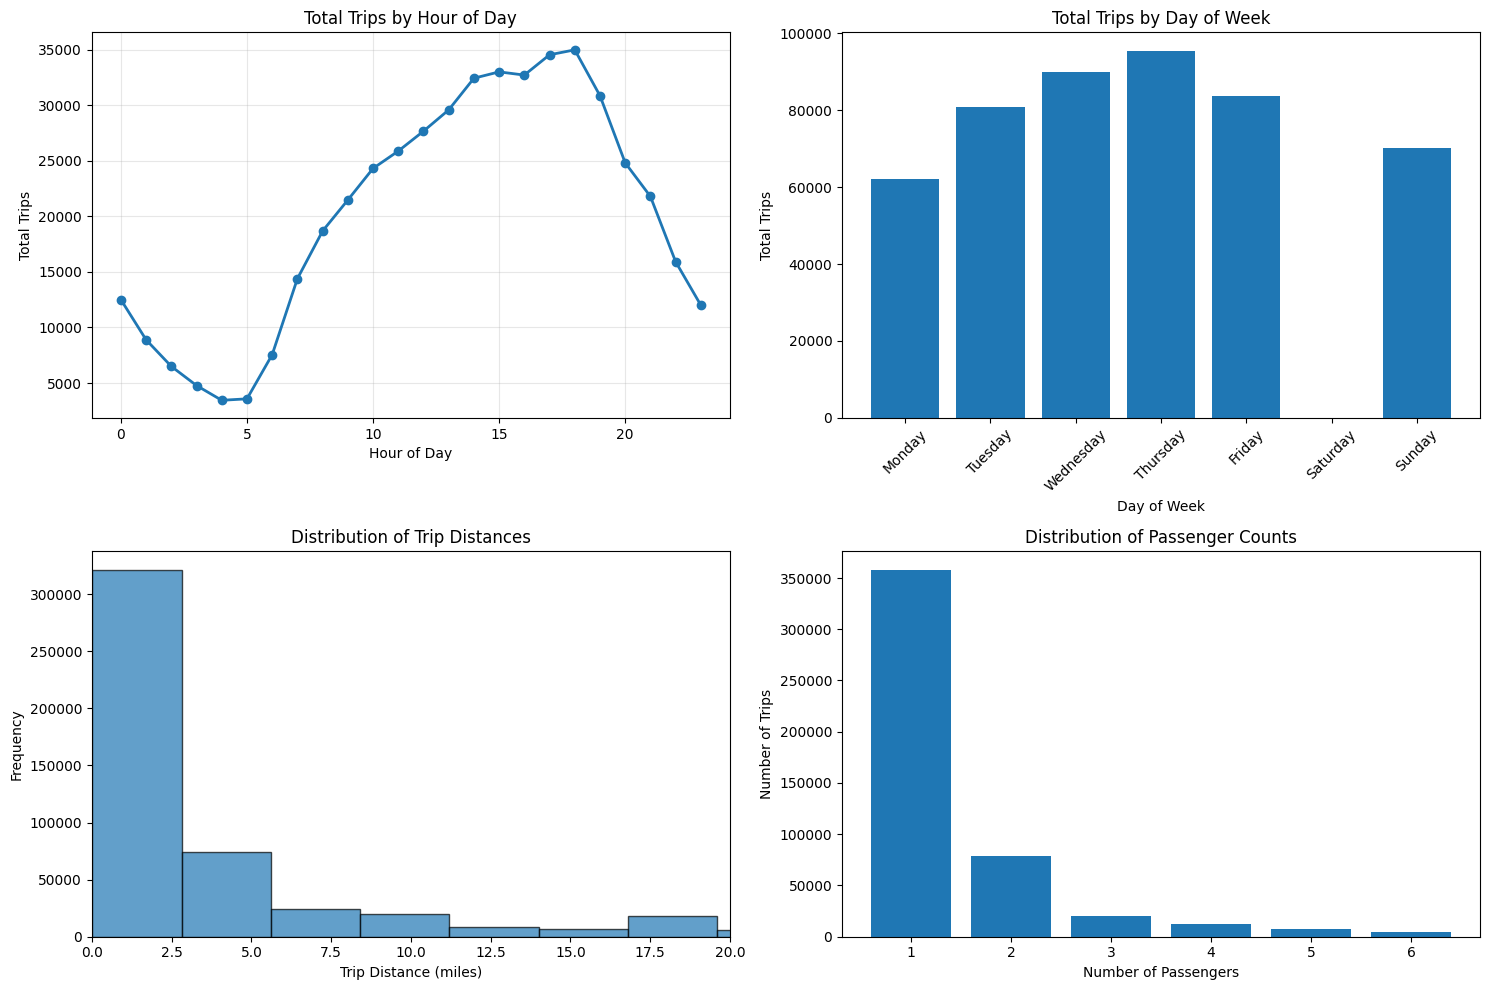

In [6]:
# Temporal patterns analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Hourly demand pattern
hourly_demand = demand_hourly.groupby('hour_of_day')['trip_count'].sum()
axes[0, 0].plot(hourly_demand.index, hourly_demand.values, marker='o', linewidth=2)
axes[0, 0].set_title('Total Trips by Hour of Day')
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Total Trips')
axes[0, 0].grid(True, alpha=0.3)

# Daily demand pattern 
daily_demand = demand_hourly.groupby('day_of_week')['trip_count'].sum()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create array and fill in actual values
daily_values = np.zeros(7)
for day_idx, count in daily_demand.items():
    daily_values[int(day_idx)] = count

# Total trips by day of week
axes[0, 1].bar(range(7), daily_values)
axes[0, 1].set_title('Total Trips by Day of Week')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Total Trips')
axes[0, 1].set_xticks(range(7))
axes[0, 1].set_xticklabels(day_names, rotation=45)

# Trip distance distribution
axes[1, 0].hist(df_clean['trip_distance'], bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Distribution of Trip Distances')
axes[1, 0].set_xlabel('Trip Distance (miles)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xlim(0, 20)  # Focus on reasonable range

# Passenger count distribution
passenger_counts = df_clean['passenger_count'].value_counts().sort_index()
axes[1, 1].bar(passenger_counts.index, passenger_counts.values)
axes[1, 1].set_title('Distribution of Passenger Counts')
axes[1, 1].set_xlabel('Number of Passengers')
axes[1, 1].set_ylabel('Number of Trips')

# Adjust layout and show plots
plt.tight_layout()
plt.show()

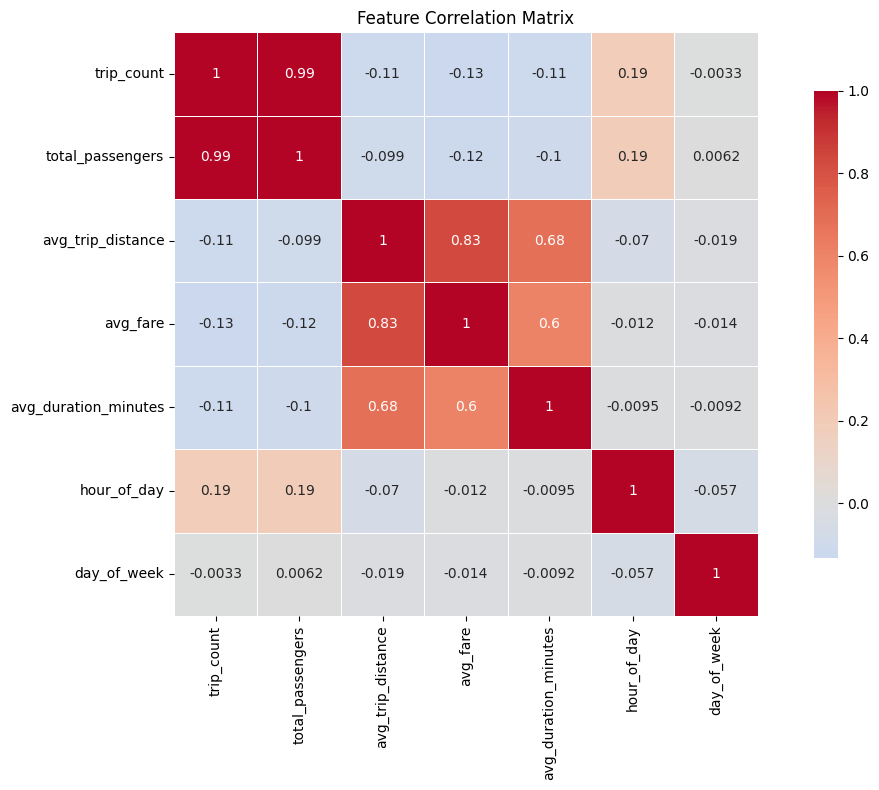

Top 10 locations by total trip volume:
             total_trips  avg_trips_per_hour  trips_std  avg_distance  \
location_id                                                             
132                32949              222.63     136.52         15.16   
237                23139              166.47     137.04          2.23   
236                22853              165.60     144.74          2.71   
161                20972              146.66     127.38          3.50   
186                17833              124.71      75.95          2.69   
138                17423              129.06      87.58          9.32   
162                17344              123.01      92.57          3.05   
142                15595              107.55      78.87          2.96   
230                14587              102.73      71.17          4.21   
170                14215              100.11      70.98          2.98   

             avg_fare  
location_id            
132             58.38  
237         

In [7]:
# Correlation analysis between features
plt.figure(figsize=(12, 8))

# Select numeric columns for correlation analysis
correlation_features = ['trip_count', 'total_passengers', 'avg_trip_distance', 
                       'avg_fare', 'avg_duration_minutes', 'hour_of_day', 'day_of_week']

correlation_matrix = demand_hourly[correlation_features].corr()

# Create heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Summary statistics by location
location_stats = demand_hourly.groupby('location_id').agg({
    'trip_count': ['sum', 'mean', 'std'],
    'avg_trip_distance': 'mean',
    'avg_fare': 'mean'
}).round(2)

location_stats.columns = ['total_trips', 'avg_trips_per_hour', 'trips_std', 
                         'avg_distance', 'avg_fare']

print("Top 10 locations by total trip volume:")
print(location_stats.sort_values('total_trips', ascending=False).head(10))

## **Data Preparation for Modelling** ##

### **Data Loading for Full Dataset** ###

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

# Loading the dataset
BASE_URL = "https://data.cityofnewyork.us/resource/4b4i-vvec.csv"
LARGE_SAMPLE_SIZE = 38000000 

print(f"Loading {LARGE_SAMPLE_SIZE:,} records for model training.")
df_full = pd.read_csv(f"{BASE_URL}?$limit={LARGE_SAMPLE_SIZE}")

print(f"Dataset loaded: {df_full.shape[0]:,} rows, {df_full.shape[1]} columns")
print(f"Memory usage: {df_full.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Check temporal coverage
df_full['tpep_pickup_datetime'] = pd.to_datetime(df_full['tpep_pickup_datetime'])
date_range = df_full['tpep_pickup_datetime'].dt.date
print(f"Date coverage: {date_range.min()} to {date_range.max()}")
print(f"Total unique days: {date_range.nunique()}")

Loading 38,000,000 records for model training.
Dataset loaded: 38,000,000 rows, 19 columns
Memory usage: 11649.8 MB
Date coverage: 2001-01-01 to 2024-01-03
Total unique days: 374


In [25]:
import pickle
import os
from datetime import datetime

def save_checkpoint(checkpoint_name, variables_dict):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"checkpoint_{checkpoint_name}_{timestamp}.pkl"
    
    try:
        with open(filename, 'wb') as f:
            pickle.dump(variables_dict, f)
        print(f"Checkpoint saved: {filename}")
        print(f"Saved {len(variables_dict)} variables")
        
        size_mb = os.path.getsize(filename) / (1024 * 1024)
        print(f"File size: {size_mb:.1f} MB")
        
        return filename
    except Exception as e:
        print(f"Checkpoint failed: {str(e)}")
        return None

def load_checkpoint(filename):
    try:
        with open(filename, 'rb') as f:
            variables_dict = pickle.load(f)
        print(f"Checkpoint loaded: {filename}")
        print(f"Loaded {len(variables_dict)} variables")
        return variables_dict
    except Exception as e:
        print(f"Load failed: {str(e)}")
        return None

def restore_from_checkpoint(checkpoint_file):
    variables = load_checkpoint(checkpoint_file)
    if variables:
        for var_name, var_value in variables.items():
            globals()[var_name] = var_value
            print(f"Restored: {var_name}")
        print(f"Recovery complete: {len(variables)} variables restored")
        return True
    return False

def list_checkpoints():
    checkpoints = [f for f in os.listdir('.') if f.startswith('checkpoint_') and f.endswith('.pkl')]
    if checkpoints:
        print("Available checkpoints:")
        for cp in sorted(checkpoints):
            size_mb = os.path.getsize(cp) / (1024 * 1024)
            print(f"  {cp} ({size_mb:.1f} MB)")
    else:
        print("No checkpoints found")
    return checkpoints

### **Comprehensive Data Cleaning and Feature Engineering** ###

Our preprocessing pipeline handles data quality issues while creating the time series structure needed for deep learning models. 

In [2]:
# Enhanced preprocessing pipeline
def clean_and_engineer_features(df):
    """
    Comprehensive data cleaning and feature engineering 
    """
    # Select core features for modeling
    core_features = [
        'tpep_pickup_datetime', 'tpep_dropoff_datetime', 
        'passenger_count', 'trip_distance', 
        'pulocationid', 'dolocationid', 'fare_amount'
    ]
    
    df_clean = df[core_features].copy()
    initial_count = len(df_clean)
    
    # Convert datetime columns
    df_clean['tpep_pickup_datetime'] = pd.to_datetime(df_clean['tpep_pickup_datetime'])
    df_clean['tpep_dropoff_datetime'] = pd.to_datetime(df_clean['tpep_dropoff_datetime'])
    
    # Remove invalid records
    df_clean = df_clean.dropna(subset=['tpep_pickup_datetime', 'pulocationid'])
    
    # Filter realistic trip parameters
    df_clean = df_clean[
        (df_clean['trip_distance'] > 0) & # Remove zero or negative distances
        (df_clean['trip_distance'] < 100) &  # Remove unrealistically long trips
        (df_clean['passenger_count'] > 0) & # Remove zero or negative passenger counts
        (df_clean['passenger_count'] <= 6) & # Remove unrealistic high passenger counts
        (df_clean['fare_amount'] > 0) & # Remove zero or negative fares
        (df_clean['fare_amount'] < 500) # Remove unrealistically high fares
    ]
    
    # Calculate trip duration
    df_clean['trip_duration_minutes'] = (
        df_clean['tpep_dropoff_datetime'] - df_clean['tpep_pickup_datetime']
    ).dt.total_seconds() / 60
    
    # Filter reasonable trip durations
    df_clean = df_clean[
        (df_clean['trip_duration_minutes'] > 1) & # Minimum 1 minute
        (df_clean['trip_duration_minutes'] < 180) # Maximum 3 hours
    ]
    
    print(f"Data cleaning: {initial_count:,} → {len(df_clean):,} records")
    print(f"Removed {initial_count - len(df_clean):,} invalid records ({(initial_count - len(df_clean))/initial_count*100:.1f}%)")
    
    return df_clean

# Apply cleaning pipeline
df_modeling = clean_and_engineer_features(df_full)

# Filter to realistic date range for NYC taxi data
df_modeling = df_modeling[
    (df_modeling['tpep_pickup_datetime'] >= '2022-01-01') & # Start from Jan 2022
    (df_modeling['tpep_pickup_datetime'] <= '2024-01-31') # End at Jan 2024
]

# Display final dataset info
print(f"After date filtering: {len(df_modeling):,} records")
print(f"New date range: {df_modeling['tpep_pickup_datetime'].min()} to {df_modeling['tpep_pickup_datetime'].max()}")

Data cleaning: 38,000,000 → 35,341,098 records
Removed 2,658,902 invalid records (7.0%)
After date filtering: 35,341,073 records
New date range: 2022-10-25 00:42:10 to 2024-01-03 19:42:57


### **Time Series Feature Engineering** ###

We create comprehensive temporal features that allow our models to understand cyclical patterns, trends, and seasonal effects in taxi demand across different time scales.

In [3]:
# Temporal feature engineering
def create_temporal_features(df):
    """
    Generate time-based features for demand forecasting models
    """
    df = df.copy()
    
    # Basic time components
    df['pickup_hour'] = df['tpep_pickup_datetime'].dt.floor('H')
    df['hour'] = df['tpep_pickup_datetime'].dt.hour
    df['day_of_week'] = df['tpep_pickup_datetime'].dt.dayofweek
    df['day_of_month'] = df['tpep_pickup_datetime'].dt.day
    df['month'] = df['tpep_pickup_datetime'].dt.month
    df['quarter'] = df['tpep_pickup_datetime'].dt.quarter
    
    # Hour cyclical features (24-hour format)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    
    # Day of week cyclical features (0-6 days)
    df['dow_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['dow_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Month cyclical features (1-12 months)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Binary temporal indicators
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
    df['is_night'] = df['hour'].isin([22, 23, 0, 1, 2, 3, 4, 5]).astype(int)
    
    return df

# Apply temporal feature engineering
df_features = create_temporal_features(df_modeling)

### **Hourly Demand Aggregation with Enhanced Features** ###

We aggregate individual trip records into hourly demand counts per location, creating our target time series. This aggregation includes statistical features that capture demand variability and trip characteristics for each time-location combination.

In [4]:
# Create hourly demand dataset with aggregated features
def create_hourly_demand_dataset(df):
    """
    Aggregate trips into hourly demand with comprehensive features
    """
    # Aggregate by hour and pickup location
    hourly_agg = df.groupby(['pickup_hour', 'pulocationid']).agg({
        'tpep_pickup_datetime': 'count',  # Trip count
        'passenger_count': ['sum', 'mean', 'std'],
        'trip_distance': ['mean', 'std', 'min', 'max'],
        'fare_amount': ['mean', 'std'],
        'trip_duration_minutes': ['mean', 'std'],
        'dolocationid': lambda x: x.nunique()  # Number of unique destinations
    }).reset_index()
    
    # Flatten column names
    hourly_agg.columns = [
        'pickup_hour', 'location_id', 'trip_count', 
        'total_passengers', 'avg_passengers', 'std_passengers',
        'avg_distance', 'std_distance', 'min_distance', 'max_distance',
        'avg_fare', 'std_fare', 'avg_duration', 'std_duration',
        'unique_destinations'
    ]
    
    # Fill NaN values 
    std_columns = ['std_passengers', 'std_distance', 'std_fare', 'std_duration']
    hourly_agg[std_columns] = hourly_agg[std_columns].fillna(0)
    
    # Add back temporal features
    hourly_agg['hour'] = hourly_agg['pickup_hour'].dt.hour
    hourly_agg['day_of_week'] = hourly_agg['pickup_hour'].dt.dayofweek
    hourly_agg['month'] = hourly_agg['pickup_hour'].dt.month
    hourly_agg['date'] = hourly_agg['pickup_hour'].dt.date
    
    # Cyclical encodings
    hourly_agg['hour_sin'] = np.sin(2 * np.pi * hourly_agg['hour'] / 24)
    hourly_agg['hour_cos'] = np.cos(2 * np.pi * hourly_agg['hour'] / 24)
    hourly_agg['dow_sin'] = np.sin(2 * np.pi * hourly_agg['day_of_week'] / 7)
    hourly_agg['dow_cos'] = np.cos(2 * np.pi * hourly_agg['day_of_week'] / 7)
    
    # Binary indicators
    hourly_agg['is_weekend'] = hourly_agg['day_of_week'].isin([5, 6]).astype(int)
    hourly_agg['is_rush_hour'] = hourly_agg['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
    
    return hourly_agg

# Create the main modeling dataset
demand_data = create_hourly_demand_dataset(df_features)

print(f"Hourly demand dataset created:")
print(f"Time range: {demand_data['pickup_hour'].min()} to {demand_data['pickup_hour'].max()}")
print(f"Unique locations: {demand_data['location_id'].nunique()}")
print(f"Total hourly records: {len(demand_data):,}")
print(f"Average trips per hour: {demand_data['trip_count'].mean():.1f}")

Hourly demand dataset created:
Time range: 2022-10-25 00:00:00 to 2024-01-03 19:00:00
Unique locations: 262
Total hourly records: 781,196
Average trips per hour: 45.2


### **Lag Features and Rolling Statistics** ###

Historical demand patterns are crucial for time series forecasting. We create lag features and rolling statistics that allow our models to learn from recent trends and seasonal patterns in taxi demand.

In [5]:
# Function to create lag features and rolling statistics
def add_lag_and_rolling_features(df, target_col='trip_count'):
    """
    Add lag features and rolling statistics for time series modeling
    """
    df = df.sort_values(['location_id', 'pickup_hour']).copy()
    
    # Create lag features for each location
    lag_periods = [1, 2, 3, 6, 12, 24, 48, 168]  # 1h, 2h, 3h, 6h, 12h, 1d, 2d, 1w
    rolling_windows = [3, 6, 12, 24, 48]  # 3h, 6h, 12h, 1d, 2d
    
    for location in df['location_id'].unique():
        location_mask = df['location_id'] == location
        location_data = df[location_mask].copy()
        
        # Lag features
        for lag in lag_periods:
            col_name = f'{target_col}_lag_{lag}h'
            df.loc[location_mask, col_name] = location_data[target_col].shift(lag)
        
        # Rolling statistics
        for window in rolling_windows:
            # Rolling mean
            col_mean = f'{target_col}_rolling_mean_{window}h'
            df.loc[location_mask, col_mean] = location_data[target_col].rolling(
                window=window, min_periods=1
            ).mean().shift(1)  # Shift to avoid data leakage
            
            # Rolling std
            col_std = f'{target_col}_rolling_std_{window}h'
            df.loc[location_mask, col_std] = location_data[target_col].rolling(
                window=window, min_periods=1
            ).std().shift(1)
            
            # Rolling min/max for trend detection
            col_min = f'{target_col}_rolling_min_{window}h'
            col_max = f'{target_col}_rolling_max_{window}h'
            df.loc[location_mask, col_min] = location_data[target_col].rolling(
                window=window, min_periods=1
            ).min().shift(1)
            df.loc[location_mask, col_max] = location_data[target_col].rolling(
                window=window, min_periods=1
            ).max().shift(1)
    
    return df

# Add lag and rolling features
print("Creating lag features and rolling statistics.")
demand_enhanced = add_lag_and_rolling_features(demand_data)

# Check feature creation
lag_cols = [col for col in demand_enhanced.columns if 'lag' in col or 'rolling' in col]
print(f"Created {len(lag_cols)} lag and rolling features")

Creating lag features and rolling statistics.
Created 28 lag and rolling features


### **Train-Validation-Test Split for Time Series** ###

Proper temporal splitting ensures our models are evaluated on unseen future data. We use chronological splits that reflect real-world deployment scenarios where we predict future demand based on historical patterns.

In [6]:
# Create time series splits
def create_time_series_splits(df, train_ratio=0.7, val_ratio=0.15):
    """
    Create chronological train/validation/test splits for time series
    """
    df_sorted = df.sort_values('pickup_hour').copy()
    
    # Calculate split indices based on time
    total_records = len(df_sorted)
    train_size = int(total_records * train_ratio)
    val_size = int(total_records * val_ratio)
    
    # Split by chronological order
    train_data = df_sorted.iloc[:train_size].copy()
    val_data = df_sorted.iloc[train_size:train_size + val_size].copy()
    test_data = df_sorted.iloc[train_size + val_size:].copy()
    
    # Print split information
    print(f"Dataset splits created:")
    print(f"Training: {len(train_data):,} records ({len(train_data)/total_records*100:.1f}%)")
    print(f"  Time range: {train_data['pickup_hour'].min()} to {train_data['pickup_hour'].max()}")
    
    print(f"Validation: {len(val_data):,} records ({len(val_data)/total_records*100:.1f}%)")
    print(f"  Time range: {val_data['pickup_hour'].min()} to {val_data['pickup_hour'].max()}")
    
    print(f"Testing: {len(test_data):,} records ({len(test_data)/total_records*100:.1f}%)")
    print(f"  Time range: {test_data['pickup_hour'].min()} to {test_data['pickup_hour'].max()}")
    
    return train_data, val_data, test_data

# Create temporal splits
train_df, val_df, test_df = create_time_series_splits(demand_enhanced)

Dataset splits created:
Training: 546,837 records (70.0%)
  Time range: 2022-10-25 00:00:00 to 2023-09-12 10:00:00
Validation: 117,179 records (15.0%)
  Time range: 2023-09-12 10:00:00 to 2023-11-07 09:00:00
Testing: 117,180 records (15.0%)
  Time range: 2023-11-07 09:00:00 to 2024-01-03 19:00:00


### **Feature Scaling and Final Preparation** ###

Neural networks require properly scaled inputs for optimal performance. We apply different scaling strategies to numerical features while preserving the temporal structure needed for sequence modeling.

In [7]:
# Feature scaling and final preparation
def prepare_features_for_modeling(train_df, val_df, test_df):
    """
    Scale features and prepare final datasets for modeling
    """
    # Define feature groups
    target_col = 'trip_count'
    
    # Numerical features for scaling
    numerical_features = [
        'avg_passengers', 'avg_distance', 'avg_fare', 'avg_duration',
        'std_passengers', 'std_distance', 'std_fare', 'std_duration',
        'unique_destinations'
    ]
    
    # Add lag and rolling features to numerical features
    lag_features = [col for col in train_df.columns if 'lag' in col or 'rolling' in col]
    numerical_features.extend(lag_features)
    
    # Cyclical and binary features
    cyclical_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']
    binary_features = ['is_weekend', 'is_rush_hour']
    
    # Categorical features
    categorical_features = ['location_id', 'hour', 'day_of_week', 'month']
    
    # Initialize scalers
    target_scaler = MinMaxScaler()
    feature_scaler = StandardScaler()
    
    # Scale target variable
    train_df['trip_count_scaled'] = target_scaler.fit_transform(
        train_df[[target_col]]
    ).flatten()
    val_df['trip_count_scaled'] = target_scaler.transform(
        val_df[[target_col]]
    ).flatten()
    test_df['trip_count_scaled'] = target_scaler.transform(
        test_df[[target_col]]
    ).flatten()
    
    # Scale numerical features
    train_df[numerical_features] = feature_scaler.fit_transform(
        train_df[numerical_features].fillna(0)
    )
    val_df[numerical_features] = feature_scaler.transform(
        val_df[numerical_features].fillna(0)
    )
    test_df[numerical_features] = feature_scaler.transform(
        test_df[numerical_features].fillna(0)
    )
    
    # Prepare feature lists for models
    model_features = numerical_features + cyclical_features + binary_features
    
    print(f"Target variable: {target_col}")
    print(f"Model features: {len(model_features)} total")
    print(f"  - Numerical: {len(numerical_features)}")
    print(f"  - Cyclical: {len(cyclical_features)}")
    print(f"  - Binary: {len(binary_features)}")
    print(f"  - Categorical: {len(categorical_features)}")
    
    return {
        'train': train_df,
        'val': val_df, 
        'test': test_df,
        'target_scaler': target_scaler,
        'feature_scaler': feature_scaler,
        'model_features': model_features,
        'categorical_features': categorical_features,
        'target_col': 'trip_count_scaled'
    }

# Finalize feature preparation
modeling_data = prepare_features_for_modeling(train_df, val_df, test_df)

# Summary of final datasets
print(f"Training samples: {len(modeling_data['train']):,}")
print(f"Validation samples: {len(modeling_data['val']):,}")
print(f"Test samples: {len(modeling_data['test']):,}")

Target variable: trip_count
Model features: 43 total
  - Numerical: 37
  - Cyclical: 4
  - Binary: 2
  - Categorical: 4
Training samples: 546,837
Validation samples: 117,179
Test samples: 117,180


## **Baseline Models Implementation** ##

### **Simple Baseline Models** ###

Before implementing complex deep learning models, we establish baseline performance using traditional forecasting methods. These baselines provide benchmarks for evaluating our deep learning approaches and ensure we capture fundamental patterns in the data.

In [8]:
# Baseline models implementation
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Evaluation metrics function
def calculate_metrics(y_true, y_pred, scaler=None):
    """Calculate MAE, RMSE, and MAPE"""
    # Ensure arrays are the same length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]
    
    # Convert to numpy arrays if not already
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Inverse transform if scaler provided
    if scaler is not None:
        y_true_unscaled = scaler.inverse_transform(y_true.reshape(-1, 1)).flatten()
        y_pred_unscaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
    else:
        y_true_unscaled = y_true
        y_pred_unscaled = y_pred
    
    # Handle any NaN or infinite values
    mask = np.isfinite(y_true_unscaled) & np.isfinite(y_pred_unscaled)
    y_true_clean = y_true_unscaled[mask]
    y_pred_clean = y_pred_unscaled[mask]
    
    if len(y_true_clean) == 0:
        return {'MAE': 0, 'RMSE': 0, 'MAPE': 0}
    
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean)) 
    
    # Calculate MAPE only for meaningful values (>= 1.0 trips)
    mape_mask = y_true_clean >= 1.0
    if np.sum(mape_mask) > 0:
        mape = np.mean(np.abs((y_true_clean[mape_mask] - y_pred_clean[mape_mask]) / y_true_clean[mape_mask])) * 100
    else:
        mape = 0
    
    return {
        'MAE': mae,
        'RMSE': rmse, 
        'MAPE': mape
    }

### **Historical Average Baseline** ###

The simplest baseline uses historical averages for the same hour and day of week combination. This captures basic cyclical patterns without considering recent trends or external factors.

In [9]:
# Historical average baseline model
def create_historical_average_baseline(train_df, val_df, test_df):
    """Create predictions based on historical averages by hour, day of week, and location"""
    
    # Calculate historical averages
    historical_patterns = {}
    
    # Primary pattern: hour + day_of_week + location_id
    primary_avg = train_df.groupby(['hour', 'day_of_week', 'location_id'])['trip_count'].mean()
    historical_patterns['primary'] = primary_avg
    
    # Fallback patterns for missing combinations
    hourly_avg = train_df.groupby(['hour', 'location_id'])['trip_count'].mean()
    historical_patterns['hourly'] = hourly_avg
    
    # Location-based average
    location_avg = train_df.groupby('location_id')['trip_count'].mean()
    historical_patterns['location'] = location_avg
    
    # Overall average
    overall_avg = train_df['trip_count'].mean()
    
    # Prediction function
    def predict_with_historical_avg(df):
        predictions = []
        
        for _, row in df.iterrows():
            # Try primary pattern first
            key_primary = (row['hour'], row['day_of_week'], row['location_id'])
            if key_primary in historical_patterns['primary']:
                pred = historical_patterns['primary'][key_primary]
            # Fallback to hourly pattern
            elif (row['hour'], row['location_id']) in historical_patterns['hourly']:
                pred = historical_patterns['hourly'][(row['hour'], row['location_id'])]
            # Fallback to location average
            elif row['location_id'] in historical_patterns['location']:
                pred = historical_patterns['location'][row['location_id']]
            # Final fallback to overall average
            else:
                pred = overall_avg
            
            predictions.append(max(0, pred))  # Ensure non-negative
        
        return np.array(predictions)
    
    # Generate predictions
    val_pred_hist = predict_with_historical_avg(val_df)
    test_pred_hist = predict_with_historical_avg(test_df)
    
    # Calculate metrics
    val_metrics = calculate_metrics(val_df['trip_count'].values, val_pred_hist)
    test_metrics = calculate_metrics(test_df['trip_count'].values, test_pred_hist)
    
    # Print results
    print("Historical Average Baseline Results:")
    print(f"Validation - MAE: {val_metrics['MAE']:.2f}, RMSE: {val_metrics['RMSE']:.2f}, MAPE: {val_metrics['MAPE']:.2f}%")
    print(f"Test - MAE: {test_metrics['MAE']:.2f}, RMSE: {test_metrics['RMSE']:.2f}, MAPE: {test_metrics['MAPE']:.2f}%")
    
    return {
        'val_predictions': val_pred_hist,
        'test_predictions': test_pred_hist,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics
    }

# Run historical average baseline
baseline_hist = create_historical_average_baseline(
    modeling_data['train'], 
    modeling_data['val'], 
    modeling_data['test']
)

Historical Average Baseline Results:
Validation - MAE: 7.86, RMSE: 18.78, MAPE: 48.57%
Test - MAE: 11.01, RMSE: 25.33, MAPE: 43.39%


### **Moving Average Baseline** ###

Moving averages capture recent trends by using the average demand from the past few time periods. We implement multiple window sizes to find the optimal lookback period for each location.

In [10]:
# Moving average baseline model
def create_moving_average_baseline(train_df, val_df, test_df, windows=[24, 48, 72, 168]):
    """Create moving average baselines with proper column names and array length handling"""
    results = {}
    best_mape = float('inf')
    best_window = None
    
    for window in windows:
        print(f"\nTesting Moving Average with {window}-hour window.")
        
        # Combine train and validation for moving average calculation
        combined_df = pd.concat([train_df, val_df]).sort_values(['location_id', 'pickup_hour'])
        
        # Initialize predictions lists
        val_predictions = []
        test_predictions = []
        
        # Process each location separately
        for location_id in val_df['location_id'].unique():
            # Get data for this location
            location_combined = combined_df[combined_df['location_id'] == location_id].copy()
            location_val = val_df[val_df['location_id'] == location_id].copy()
            location_test = test_df[test_df['location_id'] == location_id].copy()
            
            # Skip if not enough data
            if len(location_combined) < window:
                # Use mean as fallback for locations with insufficient data
                fallback_val = location_combined['trip_count'].mean() if len(location_combined) > 0 else 0
                val_predictions.extend([fallback_val] * len(location_val))
                test_predictions.extend([fallback_val] * len(location_test))
                continue
            
            # Generate validation predictions
            for i in range(len(location_val)):
                # Get the index in the combined dataframe
                val_idx = len(location_combined) - len(location_val) + i
                if val_idx >= window:
                    ma_val = location_combined.iloc[val_idx-window:val_idx]['trip_count'].mean()
                else:
                    ma_val = location_combined.iloc[:val_idx]['trip_count'].mean() if val_idx > 0 else 0
                val_predictions.append(max(0, ma_val))  # Ensure non-negative
            
            # For test predictions, we can use both train and val data
            location_full = pd.concat([location_combined, location_val]).sort_values('pickup_hour')
            
            # Generate test predictions
            for i in range(len(location_test)):
                if len(location_full) >= window:
                    ma_val = location_full.iloc[-window:]['trip_count'].mean()
                else:
                    ma_val = location_full['trip_count'].mean() if len(location_full) > 0 else 0
                test_predictions.append(max(0, ma_val))  # Ensure non-negative
                
                # Update location_full with the actual test value for next prediction
                if i < len(location_test) - 1:
                    next_row = location_test.iloc[i:i+1].copy()
                    location_full = pd.concat([location_full, next_row]).sort_values('pickup_hour')
        
        # Ensure predictions match the target lengths
        val_predictions = val_predictions[:len(val_df)]
        test_predictions = test_predictions[:len(test_df)]
        
        # Pad with mean if still short
        if len(val_predictions) < len(val_df):
            mean_val = np.mean(val_predictions) if val_predictions else 0
            val_predictions.extend([mean_val] * (len(val_df) - len(val_predictions)))
        
        if len(test_predictions) < len(test_df):
            mean_val = np.mean(test_predictions) if test_predictions else 0
            test_predictions.extend([mean_val] * (len(test_df) - len(test_predictions)))
        
        # Calculate metrics with length verification
        print(f"  Validation samples: {len(val_df)}, Predictions: {len(val_predictions)}")
        print(f"  Test samples: {len(test_df)}, Predictions: {len(test_predictions)}")
        
        # Compute metrics
        val_metrics = calculate_metrics(val_df['trip_count'].values, np.array(val_predictions))
        test_metrics = calculate_metrics(test_df['trip_count'].values, np.array(test_predictions))
        
        # Store results
        results[f'MA_{window}h'] = {
            'val_metrics': val_metrics,
            'test_metrics': test_metrics,
            'val_predictions': val_predictions,
            'test_predictions': test_predictions
        }
        
        # Print results
        print(f"  Validation - MAE: {val_metrics['MAE']:.2f}, RMSE: {val_metrics['RMSE']:.2f}, MAPE: {val_metrics['MAPE']:.2f}%")
        print(f"  Test - MAE: {test_metrics['MAE']:.2f}, RMSE: {test_metrics['RMSE']:.2f}, MAPE: {test_metrics['MAPE']:.2f}%")
        
        # Track best model based on validation MAPE
        if val_metrics['MAPE'] < best_mape:
            best_mape = val_metrics['MAPE']
            best_window = window
    
    return results, best_window

# Run moving average baselines
baseline_ma, best_ma = create_moving_average_baseline(
    modeling_data['train'], 
    modeling_data['val'], 
    modeling_data['test']
)


Testing Moving Average with 24-hour window.
  Validation samples: 117179, Predictions: 117179
  Test samples: 117180, Predictions: 117180
  Validation - MAE: 63.41, RMSE: 96.92, MAPE: 1713.38%
  Test - MAE: 62.63, RMSE: 95.99, MAPE: 1658.24%

Testing Moving Average with 48-hour window.
  Validation samples: 117179, Predictions: 117179
  Test samples: 117180, Predictions: 117180
  Validation - MAE: 63.31, RMSE: 96.58, MAPE: 1713.05%
  Test - MAE: 62.60, RMSE: 95.72, MAPE: 1662.39%

Testing Moving Average with 72-hour window.
  Validation samples: 117179, Predictions: 117179
  Test samples: 117180, Predictions: 117180
  Validation - MAE: 63.23, RMSE: 96.30, MAPE: 1712.90%
  Test - MAE: 62.56, RMSE: 95.50, MAPE: 1663.82%

Testing Moving Average with 168-hour window.
  Validation samples: 117179, Predictions: 117179
  Test samples: 117180, Predictions: 117180
  Validation - MAE: 63.05, RMSE: 95.73, MAPE: 1710.59%
  Test - MAE: 62.72, RMSE: 95.17, MAPE: 1683.52%


### **Linear Regression Baseline** ###

Linear regression provides a more sophisticated baseline by learning relationships between temporal features and demand. This model can capture interactions between different time components and location characteristics.

In [11]:
# Linear regression baseline model
def create_linear_regression_baseline(modeling_data):
    """Corrected linear regression baseline"""
    
    # Select features 
    base_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'is_weekend', 'is_rush_hour']
    
    # Add lag features 
    lag_features = [col for col in modeling_data['train'].columns 
                   if 'lag' in col and not modeling_data['train'][col].isna().all()]
    
    # Add rolling features 
    rolling_features = [col for col in modeling_data['train'].columns 
                       if 'rolling' in col and not modeling_data['train'][col].isna().all()]
    
    # Additional numerical features
    numerical_features = ['avg_passengers', 'avg_distance', 'avg_fare', 'avg_duration',
                         'unique_destinations']
    numerical_features = [col for col in numerical_features 
                         if col in modeling_data['train'].columns]
    
    # Combine all features
    feature_cols = base_features + lag_features + rolling_features + numerical_features
    
    # Prepare data
    X_train = modeling_data['train'][feature_cols].fillna(0)
    y_train = modeling_data['train']['trip_count']
    
    X_val = modeling_data['val'][feature_cols].fillna(0)
    y_val = modeling_data['val']['trip_count']
    
    X_test = modeling_data['test'][feature_cols].fillna(0)
    y_test = modeling_data['test']['trip_count']
    
    print(f"Using {len(feature_cols)} features for regression models")
    
    # Train models
    models = {
        'Linear': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
    }
    
    # Create results dictionary
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"Training {name} regression...")
        
        try:
            # Fit model
            model.fit(X_train, y_train)
            
            # Generate predictions
            val_pred = model.predict(X_val)
            test_pred = model.predict(X_test)
            
            # Ensure non-negative predictions
            val_pred = np.maximum(val_pred, 0)
            test_pred = np.maximum(test_pred, 0)
            
            # Calculate metrics
            val_metrics = calculate_metrics(y_val.values, val_pred)
            test_metrics = calculate_metrics(y_test.values, test_pred)
            
            # Store results
            results[name] = {
                'model': model,
                'val_predictions': val_pred,
                'test_predictions': test_pred,
                'val_metrics': val_metrics,
                'test_metrics': test_metrics,
                'features_used': len(feature_cols)
            }
            
            # Print results
            print(f"  Validation - MAE: {val_metrics['MAE']:.2f}, RMSE: {val_metrics['RMSE']:.2f}, MAPE: {val_metrics['MAPE']:.2f}%")
            print(f"  Test - MAE: {test_metrics['MAE']:.2f}, RMSE: {test_metrics['RMSE']:.2f}, MAPE: {test_metrics['MAPE']:.2f}%")
            
        except Exception as e:
            print(f"  Error training {name}: {str(e)}")
            continue
    
    # Identify best model based on validation MAPE
    if results:
        best_model = min(results.keys(), key=lambda x: results[x]['val_metrics']['MAE'])
        print(f"\nBest regression model: {best_model}")
        return results, best_model
    else:
        print("No regression models trained successfully")
        return {}, None

# Run regression baselines
baseline_regression, best_regression = create_linear_regression_baseline(modeling_data)

Using 39 features for regression models
Training Linear regression...
  Validation - MAE: 8.35, RMSE: 17.32, MAPE: 69.79%
  Test - MAE: 8.17, RMSE: 16.78, MAPE: 63.35%
Training Ridge regression...
  Validation - MAE: 8.35, RMSE: 17.32, MAPE: 69.79%
  Test - MAE: 8.17, RMSE: 16.78, MAPE: 63.35%
Training RandomForest regression...
  Validation - MAE: 5.51, RMSE: 13.67, MAPE: 10.25%
  Test - MAE: 5.56, RMSE: 13.66, MAPE: 10.00%

Best regression model: RandomForest


### **Baseline Results Summary** ###

We consolidate all baseline results to establish performance benchmarks for our deep learning models. These baselines represent different forecasting techniques, from simple averages to feature-based regression approaches.

In [12]:
# Summarize all baseline results
def summarize_baseline_results(baseline_hist, baseline_ma, best_ma, baseline_regression, best_regression):
    """Create comprehensive summary of all baseline model performance"""
    
    # Initialize results dictionary
    all_results = {}
    
    # Historical average
    all_results['Historical_Average'] = {
        'val_mae': baseline_hist['val_metrics']['MAE'],
        'test_mae': baseline_hist['test_metrics']['MAE'],
        'val_rmse': baseline_hist['val_metrics']['RMSE'],
        'test_rmse': baseline_hist['test_metrics']['RMSE'],
        'val_mape': baseline_hist['val_metrics']['MAPE'],
        'test_mape': baseline_hist['test_metrics']['MAPE']
    }
    
    # Best moving average 
    if best_ma and f'MA_{best_ma}h' in baseline_ma:
        best_ma_results = baseline_ma[f'MA_{best_ma}h']
        all_results[f'Moving_Average_{best_ma}h'] = {
            'val_mae': best_ma_results['val_metrics']['MAE'],
            'test_mae': best_ma_results['test_metrics']['MAE'],
            'val_rmse': best_ma_results['val_metrics']['RMSE'],
            'test_rmse': best_ma_results['test_metrics']['RMSE'],
            'val_mape': best_ma_results['val_metrics']['MAPE'],
            'test_mape': best_ma_results['test_metrics']['MAPE']
        }
    
    # Best regression model
    if best_regression and best_regression in baseline_regression:
        best_reg_results = baseline_regression[best_regression]
        all_results[f'{best_regression}_Regression'] = {
            'val_mae': best_reg_results['val_metrics']['MAE'],
            'test_mae': best_reg_results['test_metrics']['MAE'],
            'val_rmse': best_reg_results['val_metrics']['RMSE'],
            'test_rmse': best_reg_results['test_metrics']['RMSE'],
            'val_mape': best_reg_results['val_metrics']['MAPE'],
            'test_mape': best_reg_results['test_metrics']['MAPE']
        }
    
    # Create summary DataFrame
    baseline_summary = pd.DataFrame(all_results).T
    baseline_summary = baseline_summary.round(2)
    
    print("\nCorrected Baseline Model Performance Summary:")
    print(baseline_summary.to_string())
    
    # Find best overall baseline
    if not baseline_summary.empty:
        best_baseline = baseline_summary['val_mae'].idxmin()
        best_mae = baseline_summary.loc[best_baseline, 'val_mae']
        
        print(f"\nBest baseline model: {best_baseline}")
        print(f"Validation MAE to beat: {best_mae:.2f} trips/hour")
        print(f"Target for deep learning models: Beat {best_baseline} with MAE < {best_mae:.2f}")
        
        return baseline_summary, best_baseline
    else:
        print("No valid baseline results to summarize")
        return pd.DataFrame(), None

# Generate baseline summary with correct parameters
baseline_summary, best_baseline_model = summarize_baseline_results(
    baseline_hist, baseline_ma, best_ma, baseline_regression, best_regression
)

if best_baseline_model:
    print(f"\nTarget for deep learning models: Beat {best_baseline_model} with MAE < {baseline_summary.loc[best_baseline_model, 'val_mae']:.2f}")
else:
    print("No baseline models completed successfully")


Corrected Baseline Model Performance Summary:
                         val_mae  test_mae  val_rmse  test_rmse  val_mape  test_mape
Historical_Average          7.86     11.01     18.78      25.33     48.57      43.39
Moving_Average_168h        63.05     62.72     95.73      95.17   1710.59    1683.52
RandomForest_Regression     5.51      5.56     13.67      13.66     10.25      10.00

Best baseline model: RandomForest_Regression
Validation MAE to beat: 5.51 trips/hour
Target for deep learning models: Beat RandomForest_Regression with MAE < 5.51

Target for deep learning models: Beat RandomForest_Regression with MAE < 5.51


In [29]:
checkpoint_vars = {
    'df_sample': locals().get('df_sample', None),
    'df_clean': locals().get('df_clean', None),
    'modeling_data': modeling_data,
    'feature_columns': locals().get('feature_columns', None),
    'model_features': locals().get('model_features', None),
    'scaler': locals().get('scaler', None),
    'location_encoder': locals().get('location_encoder', None),
    'weather_encoder': locals().get('weather_encoder', None),
    'baseline_results': locals().get('baseline_results', None),
    'historical_avg_model': locals().get('historical_avg_model', None),
    'moving_avg_model': locals().get('moving_avg_model', None),
    'linear_model': locals().get('linear_model', None),
    'ridge_model': locals().get('ridge_model', None),
    'rf_model': locals().get('rf_model', None),
    'historical_predictions': locals().get('historical_predictions', None),
    'moving_avg_predictions': locals().get('moving_avg_predictions', None),
    'linear_predictions': locals().get('linear_predictions', None),
    'ridge_predictions': locals().get('ridge_predictions', None),
    'rf_predictions': locals().get('rf_predictions', None),
    'baseline_metrics': locals().get('baseline_metrics', None)
}

checkpoint_vars = {k: v for k, v in checkpoint_vars.items() if v is not None}
checkpoint_file_data = save_checkpoint("data_and_baseline", checkpoint_vars)

Checkpoint saved: checkpoint_data_and_baseline_20251125_071212.pkl
Saved 1 variables
File size: 316.6 MB


## **Deep Learning Models Implementation** ##

Having established solid baseline performance with RandomForest (MAE: 5.51 trips/hour), we now implement four deep learning architectures specifically designed for time series forecasting. Each model captures different aspects of temporal patterns in NYC taxi demand data.

Our target is to surpass the RandomForest baseline while maintaining robust generalization across different time periods and locations. The models implemented include LSTM networks for long-term dependencies, GRU networks for computational efficiency, Temporal CNNs for local pattern recognition, and Transformer models with attention mechanisms for complex temporal relationships.

### **Deep Learning Dependencies** ###

In [13]:
# Import libraries  
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D, 
    GlobalAveragePooling1D, Input, MultiHeadAttention,
    LayerNormalization, Embedding, Reshape, Concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
import optuna
from optuna.integration import TFKerasPruningCallback
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

### **Sequence Data Preparation** ###

In [14]:
# Prepare sequence data for deep learning models
def prepare_sequence_data(train_df, val_df, test_df, sequence_length=24, target_col='trip_count'):
    """
    Transform time series data into sequences for deep learning models
    Each sequence contains 24 hours of historical data to predict the next hour
    """
    
    # Function to create sequences
    def create_sequences(df, seq_len):
        """Create sequences for each location separately to maintain temporal order"""
        sequences = []
        targets = []
        location_ids = []
        
        # Process each location independently
        for location in df['location_id'].unique():
            location_data = df[df['location_id'] == location].sort_values('pickup_hour').copy()
            
            if len(location_data) < seq_len + 1:
                continue  # Skip locations with insufficient data
            
            # Extract features and target
            features = location_data[modeling_data['model_features']].values
            target_values = location_data[target_col].values
            
            # Create overlapping sequences
            for i in range(seq_len, len(features)):
                sequences.append(features[i-seq_len:i])
                targets.append(target_values[i])
                location_ids.append(location)
        
        return np.array(sequences), np.array(targets), np.array(location_ids)
    
    print(f"Creating sequences with {sequence_length}-hour lookback.")
    
    # Generate sequences for each dataset
    X_train, y_train, loc_train = create_sequences(train_df, sequence_length)
    X_val, y_val, loc_val = create_sequences(val_df, sequence_length)
    X_test, y_test, loc_test = create_sequences(test_df, sequence_length)
    
    # Summary of created datasets
    print(f"Sequence datasets created:")
    print(f"Training: {X_train.shape[0]:,} sequences of shape {X_train.shape[1:]}")
    print(f"Validation: {X_val.shape[0]:,} sequences of shape {X_val.shape[1:]}")
    print(f"Test: {X_test.shape[0]:,} sequences of shape {X_test.shape[1:]}")
    
    return {
        'X_train': X_train, 'y_train': y_train, 'loc_train': loc_train,
        'X_val': X_val, 'y_val': y_val, 'loc_val': loc_val,
        'X_test': X_test, 'y_test': y_test, 'loc_test': loc_test,
        'sequence_length': sequence_length,
        'n_features': X_train.shape[2]
    }

# Prepare sequence data
sequence_data = prepare_sequence_data(
    modeling_data['train'], 
    modeling_data['val'], 
    modeling_data['test'],
    sequence_length=24
)

Creating sequences with 24-hour lookback.
Sequence datasets created:
Training: 540,819 sequences of shape (24, 43)
Validation: 111,545 sequences of shape (24, 43)
Test: 111,614 sequences of shape (24, 43)


### **LSTM Implementation** ###

Long Short-Term Memory networks excel at learning long-term dependencies in sequential data. Our LSTM architecture uses unidirectional processing to capture forward temporal patterns. 

In [15]:
# Basic LSTM model implementation
def create_lstm_model(sequence_length, n_features, 
                     lstm_units_1=128, lstm_units_2=64,
                     dropout_rate=0.2, learning_rate=0.001,
                     bidirectional=False):
    """
    LSTM model for sequential pattern learning in taxi demand
    """
    
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(lstm_units_1, return_sequences=True,
                  input_shape=(sequence_length, n_features),
                  name='lstm_1'))
    model.add(Dropout(dropout_rate, name='dropout_1'))
    
    # Second LSTM layer
    model.add(LSTM(lstm_units_2, return_sequences=False, name='lstm_2'))
    model.add(Dropout(dropout_rate, name='dropout_2'))
    
    # Dense layers for final prediction
    model.add(Dense(32, activation='relu', name='dense_1'))
    model.add(Dropout(dropout_rate/2, name='dropout_3'))
    model.add(Dense(1, activation='relu', name='output'))  # Non-negative predictions
    
    # Compile with MAE loss to match our evaluation metric
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mae',
        metrics=['mae', 'mse']
    )
    
    return model

# Create and train basic LSTM model
print("Training LSTM Model.")
lstm_model = create_lstm_model(
    sequence_data['sequence_length'],
    sequence_data['n_features']
)

# Training callbacks for optimization
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Train the model
lstm_history = lstm_model.fit(
    sequence_data['X_train'], sequence_data['y_train'],
    validation_data=(sequence_data['X_val'], sequence_data['y_val']),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# Evaluate LSTM performance
lstm_val_pred = lstm_model.predict(sequence_data['X_val'])
lstm_test_pred = lstm_model.predict(sequence_data['X_test'])

lstm_val_metrics = calculate_metrics(sequence_data['y_val'], lstm_val_pred.flatten())
lstm_test_metrics = calculate_metrics(sequence_data['y_test'], lstm_test_pred.flatten())

# Print LSTM results
print(f"\nLSTM Model Results:")
print(f"Validation - MAE: {lstm_val_metrics['MAE']:.2f}, RMSE: {lstm_val_metrics['RMSE']:.2f}, MAPE: {lstm_val_metrics['MAPE']:.2f}%")
print(f"Test - MAE: {lstm_test_metrics['MAE']:.2f}, RMSE: {lstm_test_metrics['RMSE']:.2f}, MAPE: {lstm_test_metrics['MAPE']:.2f}%")

Training LSTM Model.
Epoch 1/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 174s 41ms/step - loss: 15.4072 - mae: 15.4072 - mse: 1528.2853 - val_loss: 8.4387 - val_mae: 8.4387 - val_mse: 362.8112 - learning_rate: 0.0010
Epoch 2/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 165s 39ms/step - loss: 8.4407 - mae: 8.4407 - mse: 327.7910 - val_loss: 8.0403 - val_mae: 8.0403 - val_mse: 324.7812 - learning_rate: 0.0010
Epoch 3/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 152s 36ms/step - loss: 8.0121 - mae: 8.0121 - mse: 296.6339 - val_loss: 7.7109 - val_mae: 7.7109 - val_mse: 286.0096 - learning_rate: 0.0010
Epoch 4/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 167s 40ms/step - loss: 7.8070 - mae: 7.8070 - mse: 280.1772 - val_loss: 8.4083 - val_mae: 8.4083 - val_mse: 351.1826 - learning_rate: 0.0010
Epoch 5/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 166s 39ms/step - loss: 7.6377 - mae: 7.6377 - mse: 266.9102 - val_loss: 7.4599 - val_mae: 7.4599 - val_mse: 270.9939 - learning_rate: 0.0010
Epoch 6/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 166s 39ms/step - lo

### **GRU Implementation** ###

Gated Recurrent Units provide similar capabilities to LSTMs with reduced computational complexity. GRU models typically train faster while maintaining comparable performance for many time series tasks. 

In [16]:
# GRU model implementation
def create_gru_model(sequence_length, n_features,
                    gru_units_1=128, gru_units_2=64,
                    dropout_rate=0.2, learning_rate=0.001):
    """
    GRU model is a computationally efficient alternative to LSTM
    """
    
    # Build GRU model
    model = Sequential([
        # First GRU layer
        GRU(gru_units_1, return_sequences=True,
            input_shape=(sequence_length, n_features), name='gru_1'),
        Dropout(dropout_rate, name='dropout_1'),
        
        # Second GRU layer
        GRU(gru_units_2, return_sequences=False, name='gru_2'),
        Dropout(dropout_rate, name='dropout_2'),
        
        # Final dense layers
        Dense(32, activation='relu', name='dense_1'),
        Dropout(dropout_rate/2, name='dropout_3'),
        Dense(1, activation='relu', name='output')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mae',
        metrics=['mae', 'mse']
    )
    
    return model

# Create and train GRU model
print("Training GRU Model...")
gru_model = create_gru_model(
    sequence_data['sequence_length'],
    sequence_data['n_features']
)

# Train with same callbacks as LSTM
gru_history = gru_model.fit(
    sequence_data['X_train'], sequence_data['y_train'],
    validation_data=(sequence_data['X_val'], sequence_data['y_val']),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# Evaluate GRU performance
gru_val_pred = gru_model.predict(sequence_data['X_val'])
gru_test_pred = gru_model.predict(sequence_data['X_test'])

gru_val_metrics = calculate_metrics(sequence_data['y_val'], gru_val_pred.flatten())
gru_test_metrics = calculate_metrics(sequence_data['y_test'], gru_test_pred.flatten())

# Print GRU results
print(f"\nGRU Model Results:")
print(f"Validation - MAE: {gru_val_metrics['MAE']:.2f}, RMSE: {gru_val_metrics['RMSE']:.2f}, MAPE: {gru_val_metrics['MAPE']:.2f}%")
print(f"Test - MAE: {gru_test_metrics['MAE']:.2f}, RMSE: {gru_test_metrics['RMSE']:.2f}, MAPE: {gru_test_metrics['MAPE']:.2f}%")

Training GRU Model...
Epoch 1/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 179s 42ms/step - loss: 15.8883 - mae: 15.8883 - mse: 1631.6311 - val_loss: 8.4626 - val_mae: 8.4626 - val_mse: 356.4542 - learning_rate: 0.0010
Epoch 2/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 168s 40ms/step - loss: 8.5583 - mae: 8.5583 - mse: 332.9659 - val_loss: 8.0654 - val_mae: 8.0654 - val_mse: 316.9425 - learning_rate: 0.0010
Epoch 3/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 167s 39ms/step - loss: 8.0709 - mae: 8.0709 - mse: 293.2098 - val_loss: 7.6215 - val_mae: 7.6215 - val_mse: 279.8585 - learning_rate: 0.0010
Epoch 4/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 166s 39ms/step - loss: 7.7864 - mae: 7.7864 - mse: 271.3858 - val_loss: 7.5652 - val_mae: 7.5652 - val_mse: 280.5411 - learning_rate: 0.0010
Epoch 5/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 169s 40ms/step - loss: 7.5950 - mae: 7.5950 - mse: 257.4449 - val_loss: 7.5359 - val_mae: 7.5359 - val_mse: 273.9581 - learning_rate: 0.0010
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step
3488/3488 ━━━━━━

### **Temporal CNN Implementation** ###

Convolutional Neural Networks adapted for time series data excel at detecting local temporal patterns. Our 1D CNN architecture uses dilated convolutions to capture patterns at multiple temporal scales, from short-term fluctuations to daily cycles in taxi demand.

In [ ]:
# Temporal CNN model implementation
def create_temporal_cnn_model(sequence_length, n_features,
                             num_filters=[64, 128, 64], kernel_sizes=[3, 3, 3],
                             dropout_rate=0.2, learning_rate=0.001,
                             use_dilated=True):
    """
    1D CNN for temporal pattern recognition in taxi demand
    """
    
    model = Sequential()
    
    # First convolutional block
    dilation_rate = 1  
    model.add(Conv1D(
        filters=num_filters[0], kernel_size=kernel_sizes[0],
        activation='relu', dilation_rate=dilation_rate,
        input_shape=(sequence_length, n_features), name='conv1d_1'
    ))
    model.add(MaxPooling1D(pool_size=2, name='maxpool_1'))
    model.add(Dropout(dropout_rate, name='dropout_1'))
    
    # Second convolutional block
    dilation_rate = 2 if use_dilated else 1
    model.add(Conv1D(
        filters=num_filters[1], kernel_size=kernel_sizes[1],
        activation='relu', dilation_rate=dilation_rate, name='conv1d_2'
    ))
    model.add(Dropout(dropout_rate, name='dropout_2'))
    
    # Third convolutional block 
    model.add(Conv1D(
        filters=num_filters[2], kernel_size=kernel_sizes[2],
        activation='relu', dilation_rate=1, name='conv1d_3' 
    ))
    
    # Global pooling and dense layers
    model.add(GlobalAveragePooling1D(name='global_avg_pool'))
    model.add(Dense(64, activation='relu', name='dense_1'))
    model.add(Dropout(dropout_rate, name='dropout_3'))
    model.add(Dense(32, activation='relu', name='dense_2'))
    model.add(Dropout(dropout_rate/2, name='dropout_4'))
    model.add(Dense(1, activation='relu', name='output'))
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mae',
        metrics=['mae', 'mse']
    )
    
    return model

# Create and train Temporal CNN model
print("Training Temporal CNN Model...")
cnn_model = create_temporal_cnn_model(
    sequence_data['sequence_length'],
    sequence_data['n_features'],
    use_dilated=True
)

# Train the CNN model
cnn_history = cnn_model.fit(
    sequence_data['X_train'], sequence_data['y_train'],
    validation_data=(sequence_data['X_val'], sequence_data['y_val']),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

# Evaluate CNN performance
cnn_val_pred = cnn_model.predict(sequence_data['X_val'])
cnn_test_pred = cnn_model.predict(sequence_data['X_test'])

cnn_val_metrics = calculate_metrics(sequence_data['y_val'], cnn_val_pred.flatten())
cnn_test_metrics = calculate_metrics(sequence_data['y_test'], cnn_test_pred.flatten())

# Print CNN results
print(f"\nTemporal CNN Model Results:")
print(f"Validation - MAE: {cnn_val_metrics['MAE']:.2f}, RMSE: {cnn_val_metrics['RMSE']:.2f}, MAPE: {cnn_val_metrics['MAPE']:.2f}%")
print(f"Test - MAE: {cnn_test_metrics['MAE']:.2f}, RMSE: {cnn_test_metrics['RMSE']:.2f}, MAPE: {cnn_test_metrics['MAPE']:.2f}%")

Training Temporal CNN Model...
Epoch 1/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - loss: 14.1930 - mae: 14.1930 - mse: 1022.2680 - val_loss: 10.5488 - val_mae: 10.5488 - val_mse: 541.9893 - learning_rate: 0.0010
Epoch 2/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 10.1357 - mae: 10.1357 - mse: 473.9845 - val_loss: 13.7147 - val_mae: 13.7147 - val_mse: 836.9407 - learning_rate: 0.0010
Epoch 3/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 9.5385 - mae: 9.5385 - mse: 414.6179 - val_loss: 10.8812 - val_mae: 10.8812 - val_mse: 565.2674 - learning_rate: 0.0010
Epoch 4/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 9.2542 - mae: 9.2542 - mse: 392.6575 - val_loss: 14.2520 - val_mae: 14.2520 - val_mse: 906.2943 - learning_rate: 0.0010
Epoch 5/50
4226/4226 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - loss: 8.8411 - mae: 8.8411 - mse: 353.4459 - val_loss: 12.5516 - val_mae: 12.5516 - val_mse: 730.3949 - learning_rate: 5.0000e-04
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
34

### **Transformer Implementation** ###

Transformer architectures with self-attention mechanisms can capture complex relationships across different time periods without the sequential processing limitations of RNNs. Our time series transformer uses positional encoding and multi-head attention to understand how different hours relate to each other in predicting taxi demand.

In [18]:
# Transformer model implementation
def create_transformer_model(sequence_length, n_features,
                           d_model=128, num_heads=8, num_layers=1,
                           dropout_rate=0.1, learning_rate=0.0005):
    """
    Transformer model with self-attention for complex temporal relationships
    """
    
    # Input layer
    inputs = Input(shape=(sequence_length, n_features), name='input')
    
    # Project input features to d_model dimensions
    x = Dense(d_model, name='input_projection')(inputs)
    
    # Add positional encoding for temporal information
    positions = tf.range(start=0, limit=sequence_length, dtype=tf.float32)
    positions = positions[tf.newaxis, :, tf.newaxis]
    
    # Positional encoding
    pos_encoding = tf.sin(positions / 10000.0) 
    x = x + pos_encoding
    
    # Transformer blocks
    for i in range(num_layers):
        # Multi-head self-attention
        attn_output = MultiHeadAttention(
            num_heads=num_heads, key_dim=d_model//num_heads,
            name=f'attention_{i}'
        )(x, x)
        
        # Dropout after attention
        attn_output = Dropout(dropout_rate, name=f'attn_dropout_{i}')(attn_output)
        
        # Add & Norm
        x = LayerNormalization(name=f'norm1_{i}')(x + attn_output)
        
        # Feed Forward Network
        ffn_output = Dense(d_model*2, activation='relu', name=f'ffn_1_{i}')(x)
        ffn_output = Dropout(dropout_rate, name=f'ffn_dropout_{i}')(ffn_output)
        ffn_output = Dense(d_model, name=f'ffn_2_{i}')(ffn_output)
        
        # Add & Norm
        x = LayerNormalization(name=f'norm2_{i}')(x + ffn_output)
    
    # Global pooling and output
    x = GlobalAveragePooling1D(name='global_pool')(x)
    x = Dense(64, activation='relu', name='dense_1')(x)
    x = Dropout(dropout_rate*2, name='final_dropout')(x)
    outputs = Dense(1, activation='relu', name='output')(x)
    
    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mae',
        metrics=['mae', 'mse']
    )
    
    return model

# Create and train Transformer model
print("Training Transformer Model.")
transformer_model = create_transformer_model(
    sequence_data['sequence_length'],
    sequence_data['n_features']
)

# Train transformer 
transformer_callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

# Train the Transformer model
transformer_history = transformer_model.fit(
    sequence_data['X_train'], sequence_data['y_train'],
    validation_data=(sequence_data['X_val'], sequence_data['y_val']),
    epochs=60,
    batch_size=64,  
    callbacks=transformer_callbacks,
    verbose=1
)

# Evaluate Transformer performance
transformer_val_pred = transformer_model.predict(sequence_data['X_val'])
transformer_test_pred = transformer_model.predict(sequence_data['X_test'])

# Calculate metrics
transformer_val_metrics = calculate_metrics(sequence_data['y_val'], transformer_val_pred.flatten())
transformer_test_metrics = calculate_metrics(sequence_data['y_test'], transformer_test_pred.flatten())

# Print Transformer results
print(f"\nTransformer Model Results:")
print(f"Validation - MAE: {transformer_val_metrics['MAE']:.2f}, RMSE: {transformer_val_metrics['RMSE']:.2f}, MAPE: {transformer_val_metrics['MAPE']:.2f}%")
print(f"Test - MAE: {transformer_test_metrics['MAE']:.2f}, RMSE: {transformer_test_metrics['RMSE']:.2f}, MAPE: {transformer_test_metrics['MAPE']:.2f}%")

Training Transformer Model.
Epoch 1/60
8451/8451 ━━━━━━━━━━━━━━━━━━━━ 139s 16ms/step - loss: 18.4209 - mae: 18.4209 - mse: 1704.3824 - val_loss: 10.3523 - val_mae: 10.3523 - val_mse: 534.3892 - learning_rate: 5.0000e-04
Epoch 2/60
8451/8451 ━━━━━━━━━━━━━━━━━━━━ 137s 16ms/step - loss: 9.4206 - mae: 9.4206 - mse: 403.9785 - val_loss: 9.4821 - val_mae: 9.4821 - val_mse: 454.2635 - learning_rate: 5.0000e-04
Epoch 3/60
8451/8451 ━━━━━━━━━━━━━━━━━━━━ 138s 16ms/step - loss: 8.8723 - mae: 8.8723 - mse: 358.0623 - val_loss: 9.4508 - val_mae: 9.4508 - val_mse: 445.4710 - learning_rate: 5.0000e-04
Epoch 4/60
8451/8451 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - loss: 8.5667 - mae: 8.5667 - mse: 334.1151 - val_loss: 8.9482 - val_mae: 8.9482 - val_mse: 401.5755 - learning_rate: 5.0000e-04
Epoch 5/60
8451/8451 ━━━━━━━━━━━━━━━━━━━━ 140s 17ms/step - loss: 8.3866 - mae: 8.3866 - mse: 320.7989 - val_loss: 8.7238 - val_mae: 8.7238 - val_mse: 401.0419 - learning_rate: 5.0000e-04
Epoch 6/60
8451/8451 ━━━━━━━━━━━

### **Deep Learning Results Summary** ###

In [19]:
def summarize_deep_learning_results():
    """
    Comprehensive comparison of all deep learning models against baseline
    """
    
    # Collect all results
    dl_results = {
        'LSTM': {
            'val_mae': lstm_val_metrics['MAE'],
            'test_mae': lstm_test_metrics['MAE'],
            'val_rmse': lstm_val_metrics['RMSE'],
            'test_rmse': lstm_test_metrics['RMSE'],
            'val_mape': lstm_val_metrics['MAPE'],
            'test_mape': lstm_test_metrics['MAPE']
        },
        'GRU': {
            'val_mae': gru_val_metrics['MAE'],
            'test_mae': gru_test_metrics['MAE'],
            'val_rmse': gru_val_metrics['RMSE'],
            'test_rmse': gru_test_metrics['RMSE'],
            'val_mape': gru_val_metrics['MAPE'],
            'test_mape': gru_test_metrics['MAPE']
        },
        'Temporal_CNN': {
            'val_mae': cnn_val_metrics['MAE'],
            'test_mae': cnn_test_metrics['MAE'],
            'val_rmse': cnn_val_metrics['RMSE'],
            'test_rmse': cnn_test_metrics['RMSE'],
            'val_mape': cnn_val_metrics['MAPE'],
            'test_mape': cnn_test_metrics['MAPE']
        },
        'Transformer': {
            'val_mae': transformer_val_metrics['MAE'],
            'test_mae': transformer_test_metrics['MAE'],
            'val_rmse': transformer_val_metrics['RMSE'],
            'test_rmse': transformer_test_metrics['RMSE'],
            'val_mape': transformer_val_metrics['MAPE'],
            'test_mape': transformer_test_metrics['MAPE']
        }
    }
    
    # Create comparison DataFrame
    dl_summary = pd.DataFrame(dl_results).T
    dl_summary = dl_summary.round(2)
    
    print("\nDeep Learning Models Performance Summary:")
    print(dl_summary.to_string())
    
    # Compare with baseline
    baseline_target = 5.51  # RandomForest MAE
    
    print(f"\nComparison with RandomForest Baseline (MAE: {baseline_target}):")
    
    # Detailed comparison
    for model_name, metrics in dl_results.items():
        val_mae = metrics['val_mae']
        improvement = ((baseline_target - val_mae) / baseline_target) * 100
        
        if val_mae < baseline_target:
            print(f"{model_name}: MAE {val_mae:.2f} - IMPROVED by {improvement:.1f}%")
        else:
            print(f"{model_name}: MAE {val_mae:.2f} - WORSE by {-improvement:.1f}%")
    
    # Find best model
    best_model = dl_summary['val_mae'].idxmin()
    best_mae = dl_summary.loc[best_model, 'val_mae']
    
    print(f"\nBest Deep Learning Model: {best_model}")
    print(f"Validation MAE: {best_mae:.2f}")
    
    if best_mae < baseline_target:
        improvement = ((baseline_target - best_mae) / baseline_target) * 100
        print(f"Beat baseline by {improvement:.1f}%")
    else:
        gap = ((best_mae - baseline_target) / baseline_target) * 100
        print(f"Needs Optimization: {gap:.1f}% gap to baseline")
    
    return dl_summary, best_model

# Print results summary
dl_summary, best_dl_model = summarize_deep_learning_results()


Deep Learning Models Performance Summary:
              val_mae  test_mae  val_rmse  test_rmse  val_mape  test_mape
LSTM             6.97      6.98     15.33      14.98     38.62      28.82
GRU              8.46      8.30     18.88      18.48     42.96      35.60
Temporal_CNN    10.55     10.01     23.28      21.66     57.58      37.50
Transformer      7.52      7.30     17.52      15.99     39.79      29.27

Comparison with RandomForest Baseline (MAE: 5.51):
LSTM: MAE 6.97 - WORSE by 26.5%
GRU: MAE 8.46 - WORSE by 53.6%
Temporal_CNN: MAE 10.55 - WORSE by 91.4%
Transformer: MAE 7.52 - WORSE by 36.5%

Best Deep Learning Model: LSTM
Validation MAE: 6.97
Needs Optimization: 26.5% gap to baseline


In [27]:
checkpoint_vars = {
    'modeling_data': modeling_data,
    'sequence_data': sequence_data,
    'baseline_results': locals().get('baseline_results', None),
    'lstm_model': locals().get('lstm_model', None),
    'gru_model': locals().get('gru_model', None), 
    'cnn_model': locals().get('cnn_model', None),
    'transformer_model': locals().get('transformer_model', None),
    'lstm_val_pred': locals().get('lstm_val_pred', None),
    'lstm_test_pred': locals().get('lstm_test_pred', None),
    'gru_val_pred': locals().get('gru_val_pred', None),
    'gru_test_pred': locals().get('gru_test_pred', None),
    'cnn_val_pred': locals().get('cnn_val_pred', None),
    'cnn_test_pred': locals().get('cnn_test_pred', None),
    'transformer_val_pred': locals().get('transformer_val_pred', None),
    'transformer_test_pred': locals().get('transformer_test_pred', None),
    'lstm_val_metrics': locals().get('lstm_val_metrics', None),
    'lstm_test_metrics': locals().get('lstm_test_metrics', None),
    'gru_val_metrics': locals().get('gru_val_metrics', None),
    'gru_test_metrics': locals().get('gru_test_metrics', None),
    'cnn_val_metrics': locals().get('cnn_val_metrics', None),
    'cnn_test_metrics': locals().get('cnn_test_metrics', None),
    'transformer_val_metrics': locals().get('transformer_val_metrics', None),
    'transformer_test_metrics': locals().get('transformer_test_metrics', None),
    'lstm_history': locals().get('lstm_history', None),
    'gru_history': locals().get('gru_history', None),
    'cnn_history': locals().get('cnn_history', None),
    'transformer_history': locals().get('transformer_history', None),
    'dl_summary': locals().get('dl_summary', None),
    'best_dl_model': locals().get('best_dl_model', None)
}

checkpoint_vars = {k: v for k, v in checkpoint_vars.items() if v is not None}
checkpoint_file_before = save_checkpoint("before_hpo", checkpoint_vars)

Checkpoint saved: checkpoint_before_hpo_20251125_070637.pkl
Saved 28 variables
File size: 6352.3 MB


## **Hyperparameter Optimization Implementation** ##

Our deep learning models need hyperparameter optimization to surpass the RandomForest baseline. We implement systematic HPO using Optuna to find optimal configurations for each architecture. The target is to achieve MAE < 5.51 to beat our baseline performance.

### **HPO Setup** ###

In [20]:
# Import libraries 
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.samplers import TPESampler
import joblib
from functools import partial
import gc

# Configure Optuna for reproducible results
optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=42)

### **LSTM HPO Function** ###

In [21]:
# LSTM Hyperparameter Optimization function
def lstm_hpo_objective(trial, X_train=None, y_train=None, X_val=None, y_val=None):
    """
    Optuna objective function for LSTM hyperparameter optimization
    """
    # Sample hyperparameters 
    lstm_units_1 = trial.suggest_categorical('lstm_units_1', [64, 96, 128, 160])
    lstm_units_2 = trial.suggest_categorical('lstm_units_2', [64, 96, 128, 160])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    learning_rate = trial.suggest_float('learning_rate', 0.0005, 0.002, log=True)
    batch_size = trial.suggest_categorical('batch_size', [256, 512])
    
    # Clear memory
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Build improved LSTM model
    model = Sequential([
        LSTM(lstm_units_1, return_sequences=True,
             input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout_rate),
        LSTM(lstm_units_2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate/2),
        Dense(1, activation='relu')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mae',
        metrics=['mae']
    )
    
    try:
        # Train model with early stopping 
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=25,
            batch_size=batch_size,
            callbacks=[EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)],
            verbose=0
        )
        
        # Return best validation MAE
        best_mae = min(history.history['val_mae'])
        return best_mae
        
    except Exception as e:
        print(f"Trial failed: {str(e)}")
        return float('inf')

# Run LSTM HPO
print("Starting LSTM Hyperparameter Optimization...")
lstm_study = optuna.create_study(direction='minimize', sampler=sampler, study_name='lstm_hpo')

# Partial function to pass data
lstm_objective = partial(
    lstm_hpo_objective,
    X_train=sequence_data['X_train'],
    y_train=sequence_data['y_train'],
    X_val=sequence_data['X_val'],
    y_val=sequence_data['y_val']
)

# Optimize for 20 trials or 1 hour
lstm_study.optimize(lstm_objective, n_trials=10, timeout=1800)

# Print best LSTM HPO results
print(f"LSTM HPO Complete.")
print(f"Best MAE: {lstm_study.best_value:.3f}")
print(f"Best parameters: {lstm_study.best_params}")


Starting LSTM Hyperparameter Optimization...

LSTM HPO Complete.
Best MAE: 7.243
Best parameters: {'lstm_units_1': 96, 'lstm_units_2': 160, 'dropout_rate': 0.22022300234864176, 'learning_rate': 0.0013343574182140066, 'batch_size': 512}


### **GRU HPO Function** ###

In [22]:
# GRU Hyperparameter Optimization function
def gru_hpo_objective(trial, X_train=None, y_train=None, X_val=None, y_val=None):
    """
    Optuna objective function for GRU hyperparameter optimization
    """
    # Sample hyperparameters using Optuna
    gru_units_1 = trial.suggest_categorical('gru_units_1', [64, 96, 128, 160])
    gru_units_2 = trial.suggest_categorical('gru_units_2', [64, 96, 128, 160])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    learning_rate = trial.suggest_float('learning_rate', 0.0005, 0.002, log=True)
    batch_size = trial.suggest_categorical('batch_size', [256, 512])
    
    # Clear memory
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Build improved GRU model
    model = Sequential([
        GRU(gru_units_1, return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout_rate),
        GRU(gru_units_2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate/2),
        Dense(1, activation='relu')
    ])
    
    # Compile model
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mae',
        metrics=['mae']
    )
    
    try:
        # Train the model with early stopping
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=25,
            batch_size=batch_size,
            callbacks=[EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)],
            verbose=0
        )
        
        return min(history.history['val_mae'])
        
    except Exception as e:
        print(f"Trial failed: {str(e)}")
        return float('inf')

# Run GRU HPO
print("Starting GRU Hyperparameter Optimization...")
gru_study = optuna.create_study(direction='minimize', sampler=sampler, study_name='gru_hpo')

# Partial function to pass data
gru_objective = partial(
    gru_hpo_objective,
    X_train=sequence_data['X_train'],
    y_train=sequence_data['y_train'],
    X_val=sequence_data['X_val'],
    y_val=sequence_data['y_val']
)

# Optimize for 20 trials or 1 hour
gru_study.optimize(gru_objective, n_trials=10, timeout=1800)

# Print best GRU HPO results
print(f"GRU HPO Complete.")
print(f"Best MAE: {gru_study.best_value:.3f}")
print(f"Best parameters: {gru_study.best_params}")

Starting GRU Hyperparameter Optimization...
GRU HPO Complete.
Best MAE: 7.270
Best parameters: {'gru_units_1': 64, 'gru_units_2': 96, 'dropout_rate': 0.22237057894447587, 'learning_rate': 0.0006066716167545476, 'batch_size': 512}


### **Transformer HPO Function** ###

In [ ]:
# Transformer Hyperparameter Optimization function
def transformer_hpo_objective(trial, X_train=None, y_train=None, X_val=None, y_val=None):
    """
    Optuna objective function for Transformer hyperparameter optimization
    """

    # Sample hyperparameters
    d_model = trial.suggest_categorical('d_model', [64, 128, 192])
    num_heads = trial.suggest_categorical('num_heads', [2, 4])
    learning_rate = trial.suggest_float('learning_rate', 0.0005, 0.002, log=True)
    batch_size = trial.suggest_categorical('batch_size', [128, 256])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.3)
    
    # Ensure num_heads divides d_model
    if d_model % num_heads != 0:
        return float('inf')
    
    # Clear memory
    tf.keras.backend.clear_session()
    gc.collect()
    
    # Build transformer model
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = Dense(d_model)(inputs)
    
    # Add positional encoding
    positions = tf.range(start=0, limit=X_train.shape[1], dtype=tf.float32)
    positions = positions[tf.newaxis, :, tf.newaxis]
    pos_encoding = tf.sin(positions / 10000.0)
    x = x + pos_encoding
    
    # Multi-head attention
    attn_output = MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=d_model//num_heads
    )(x, x)
    attn_output = Dropout(dropout_rate)(attn_output)
    x = LayerNormalization()(x + attn_output)
    
    # Feed forward
    ffn_output = Dense(d_model*2, activation='relu')(x)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    ffn_output = Dense(d_model)(ffn_output)
    x = LayerNormalization()(x + ffn_output)
    
    # Output layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='relu')(x)
    
    # Compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mae',
        metrics=['mae']
    )
    
    try:
        # Train the model with early stopping
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=30,
            batch_size=batch_size,
            callbacks=[EarlyStopping(monitor='val_mae', patience=8, restore_best_weights=True)],
            verbose=0
        )
        
        return min(history.history['val_mae'])
        
    except Exception as e:
        print(f"Trial failed: {str(e)}")
        return float('inf')

# Run Transformer HPO
print("Starting Transformer Hyperparameter Optimization...")
transformer_study = optuna.create_study(direction='minimize', sampler=sampler, study_name='transformer_hpo')

# Partial function to pass data
transformer_objective = partial(
    transformer_hpo_objective,
    X_train=sequence_data['X_train'],
    y_train=sequence_data['y_train'],
    X_val=sequence_data['X_val'],
    y_val=sequence_data['y_val']
)

# Optimize for 7 trials or 30 minutes
transformer_study.optimize(transformer_objective, n_trials=7, timeout=1800)

# Print best Transformer HPO results
print(f"Transformer HPO Complete.")
print(f"Best MAE: {transformer_study.best_value:.3f}")
print(f"Best parameters: {transformer_study.best_params}")


Starting Transformer Hyperparameter Optimization...
Transformer HPO Complete.
Best MAE: 7.980
Best parameters: {'d_model': 128, 'num_heads': 4, 'learning_rate': 0.0005332562317538382, 'batch_size': 128, 'dropout_rate': 0.1130103185970559}


In [31]:
checkpoint_vars = {
    'modeling_data': modeling_data,
    'sequence_data': sequence_data,
    'baseline_results': locals().get('baseline_results', None),
    'lstm_model': locals().get('lstm_model', None),
    'gru_model': locals().get('gru_model', None),
    'cnn_model': locals().get('cnn_model', None),
    'transformer_model': locals().get('transformer_model', None),
    'lstm_val_pred': locals().get('lstm_val_pred', None),
    'lstm_test_pred': locals().get('lstm_test_pred', None),
    'gru_val_pred': locals().get('gru_val_pred', None),
    'gru_test_pred': locals().get('gru_test_pred', None),
    'cnn_val_pred': locals().get('cnn_val_pred', None),
    'cnn_test_pred': locals().get('cnn_test_pred', None),
    'transformer_val_pred': locals().get('transformer_val_pred', None),
    'transformer_test_pred': locals().get('transformer_test_pred', None),
    'lstm_val_metrics': locals().get('lstm_val_metrics', None),
    'lstm_test_metrics': locals().get('lstm_test_metrics', None),
    'gru_val_metrics': locals().get('gru_val_metrics', None),
    'gru_test_metrics': locals().get('gru_test_metrics', None),
    'cnn_val_metrics': locals().get('cnn_val_metrics', None),
    'cnn_test_metrics': locals().get('cnn_test_metrics', None),
    'transformer_val_metrics': locals().get('transformer_val_metrics', None),
    'transformer_test_metrics': locals().get('transformer_test_metrics', None),
    'lstm_history': locals().get('lstm_history', None),
    'gru_history': locals().get('gru_history', None),
    'cnn_history': locals().get('cnn_history', None),
    'transformer_history': locals().get('transformer_history', None),
    'dl_summary': locals().get('dl_summary', None),
    'best_dl_model': locals().get('best_dl_model', None),
    'lstm_study': lstm_study,
    'gru_study': gru_study,
    'transformer_study': transformer_study,
    'sampler': locals().get('sampler', None),
    'lstm_objective': locals().get('lstm_objective', None),
    'gru_objective': locals().get('gru_objective', None),
    'transformer_objective': locals().get('transformer_objective', None)
}

checkpoint_vars = {k: v for k, v in checkpoint_vars.items() if v is not None}
checkpoint_file_hpo = save_checkpoint("after_hpo_studies", checkpoint_vars)

Checkpoint saved: checkpoint_after_hpo_studies_20251125_075851.pkl
Saved 35 variables
File size: 6352.3 MB


### **Train Best Models** ###

In [33]:
# Train final models with optimized hyperparameters
def train_best_models(lstm_params, gru_params, transformer_params):
    """
    Train final models with optimized hyperparameters
    """
    results = {}
    
    # Train best LSTM
    print("Training optimized LSTM.")
    tf.keras.backend.clear_session()
    
    # Build LSTM with best parameters
    lstm_model = Sequential([
        LSTM(lstm_params['lstm_units_1'], return_sequences=True,
             input_shape=(sequence_data['X_train'].shape[1], sequence_data['X_train'].shape[2])),
        Dropout(lstm_params['dropout_rate']),
        LSTM(lstm_params['lstm_units_2'], return_sequences=False),
        Dropout(lstm_params['dropout_rate']),
        Dense(32, activation='relu'),
        Dropout(lstm_params['dropout_rate']/2),
        Dense(1, activation='relu')
    ])
    
    # Compile LSTM
    lstm_model.compile(
        optimizer=Adam(learning_rate=lstm_params['learning_rate']),
        loss='mae',
        metrics=['mae']
    )
    
    # Train LSTM
    lstm_model.fit(
        sequence_data['X_train'], sequence_data['y_train'],
        validation_data=(sequence_data['X_val'], sequence_data['y_val']),
        epochs=80,
        batch_size=lstm_params['batch_size'],
        callbacks=[EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True)],
        verbose=1
    )
    
    # Evaluate LSTM
    lstm_val_pred = lstm_model.predict(sequence_data['X_val'])
    lstm_test_pred = lstm_model.predict(sequence_data['X_test'])
    
    # Store results
    results['LSTM_Optimized'] = {
        'val_metrics': calculate_metrics(sequence_data['y_val'], lstm_val_pred.flatten()),
        'test_metrics': calculate_metrics(sequence_data['y_test'], lstm_test_pred.flatten()),
        'model': lstm_model
    }
    
    # Train best GRU
    print("Training optimized GRU.")
    tf.keras.backend.clear_session()
    
    # Build GRU with best parameters
    gru_model = Sequential([
        GRU(gru_params['gru_units_1'], return_sequences=True,
            input_shape=(sequence_data['X_train'].shape[1], sequence_data['X_train'].shape[2])),
        Dropout(gru_params['dropout_rate']),
        GRU(gru_params['gru_units_2'], return_sequences=False),
        Dropout(gru_params['dropout_rate']),
        Dense(32, activation='relu'),
        Dropout(gru_params['dropout_rate']/2),
        Dense(1, activation='relu')
    ])
    
    # Compile GRU
    gru_model.compile(
        optimizer=Adam(learning_rate=gru_params['learning_rate']),
        loss='mae',
        metrics=['mae']
    )
    
    # Train GRU
    gru_model.fit(
        sequence_data['X_train'], sequence_data['y_train'],
        validation_data=(sequence_data['X_val'], sequence_data['y_val']),
        epochs=80,
        batch_size=gru_params['batch_size'],
        callbacks=[EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True)],
        verbose=1
    )
    
    # Evaluate GRU
    gru_val_pred = gru_model.predict(sequence_data['X_val'])
    gru_test_pred = gru_model.predict(sequence_data['X_test'])
    
    # Store results
    results['GRU_Optimized'] = {
        'val_metrics': calculate_metrics(sequence_data['y_val'], gru_val_pred.flatten()),
        'test_metrics': calculate_metrics(sequence_data['y_test'], gru_test_pred.flatten()),
        'model': gru_model
    }
    
    # Train best Transformer
    print("Training optimized Transformer.")
    tf.keras.backend.clear_session()
    
    # Build transformer with best params
    inputs = Input(shape=(sequence_data['X_train'].shape[1], sequence_data['X_train'].shape[2]))
    x = Dense(transformer_params['d_model'])(inputs)
    
    # Add positional encoding
    positions = tf.range(start=0, limit=sequence_data['X_train'].shape[1], dtype=tf.float32)
    positions = positions[tf.newaxis, :, tf.newaxis]
    pos_encoding = tf.sin(positions / 10000.0)
    x = x + pos_encoding
    
    # Multi-head attention
    attn_output = MultiHeadAttention(
        num_heads=transformer_params['num_heads'], 
        key_dim=transformer_params['d_model']//transformer_params['num_heads']
    )(x, x)
    attn_output = Dropout(transformer_params['dropout_rate'])(attn_output)
    x = LayerNormalization()(x + attn_output)
    
    # Feed forward
    ffn_output = Dense(transformer_params['d_model']*2, activation='relu')(x)
    ffn_output = Dropout(transformer_params['dropout_rate'])(ffn_output)
    ffn_output = Dense(transformer_params['d_model'])(ffn_output)
    x = LayerNormalization()(x + ffn_output)
    
    # Output layers
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(transformer_params['dropout_rate'])(x)
    outputs = Dense(1, activation='relu')(x)
    
    # Compile Transformer
    transformer_model = Model(inputs=inputs, outputs=outputs)
    transformer_model.compile(
        optimizer=Adam(learning_rate=transformer_params['learning_rate']),
        loss='mae',
        metrics=['mae']
    )
    
    # Train Transformer
    transformer_model.fit(
        sequence_data['X_train'], sequence_data['y_train'],
        validation_data=(sequence_data['X_val'], sequence_data['y_val']),
        epochs=100,
        batch_size=transformer_params['batch_size'],
        callbacks=[EarlyStopping(monitor='val_mae', patience=20, restore_best_weights=True)],
        verbose=1
    )
    
    # Evaluate Transformer
    transformer_val_pred = transformer_model.predict(sequence_data['X_val'])
    transformer_test_pred = transformer_model.predict(sequence_data['X_test'])
    
    # Store results
    results['Transformer_Optimized'] = {
        'val_metrics': calculate_metrics(sequence_data['y_val'], transformer_val_pred.flatten()),
        'test_metrics': calculate_metrics(sequence_data['y_test'], transformer_test_pred.flatten()),
        'model': transformer_model
    }
    
    return results

# Train final optimized models
optimized_results = train_best_models(
    lstm_study.best_params,
    gru_study.best_params,
    transformer_study.best_params
)

Training optimized LSTM.
Epoch 1/80
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 177s 165ms/step - loss: 20.1949 - mae: 20.1949 - val_loss: 9.7129 - val_mae: 9.7129
Epoch 2/80
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 165s 156ms/step - loss: 8.8891 - mae: 8.8891 - val_loss: 8.2622 - val_mae: 8.2622
Epoch 3/80
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 160s 151ms/step - loss: 8.2206 - mae: 8.2206 - val_loss: 8.1379 - val_mae: 8.1379
Epoch 4/80
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 162s 153ms/step - loss: 7.9417 - mae: 7.9417 - val_loss: 7.9084 - val_mae: 7.9084
Epoch 5/80
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 160s 151ms/step - loss: 7.8164 - mae: 7.8164 - val_loss: 7.5754 - val_mae: 7.5754
Epoch 6/80
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 162s 153ms/step - loss: 7.7124 - mae: 7.7124 - val_loss: 7.5982 - val_mae: 7.5982
Epoch 7/80
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 160s 151ms/step - loss: 7.5806 - mae: 7.5806 - val_loss: 7.6444 - val_mae: 7.6444
Epoch 8/80
1057/1057 ━━━━━━━━━━━━━━━━━━━━ 164s 155ms/step - loss: 7.5172 - mae: 7.5172 - val_loss: 7.4557

### **HPO Results Summary** ###

In [34]:
# Summarize HPO results
def summarize_hpo_results():
    """
    Compare HPO results with baseline and original DL models
    """
    
    print("Hyperparameter Optimization Results Summary:")
    
    # Baseline MAE from RandomForest
    baseline_mae = 5.51
    
    print(f"\nHPO Performance vs Baseline (MAE: {baseline_mae}):")
    
    # Detailed comparison
    for model_name, results in optimized_results.items():
        val_mae = results['val_metrics']['MAE']
        test_mae = results['test_metrics']['MAE']
        val_mape = results['val_metrics']['MAPE']
        
        if val_mae < baseline_mae:
            improvement = ((baseline_mae - val_mae) / baseline_mae) * 100
            print(f"  Validation MAE: {val_mae:.2f} - BEATS baseline by {improvement:.1f}%")
            print(f"  Test MAE: {test_mae:.2f}")
            print(f"  MAPE: {val_mape:.1f}%")
        else:
            gap = ((val_mae - baseline_mae) / baseline_mae) * 100
            print(f"  Validation MAE: {val_mae:.2f} - Gap: {gap:.1f}%")
            print(f"  Test MAE: {test_mae:.2f}")
            print(f"  MAPE: {val_mape:.1f}%")
        
        print()
    
    # Find best overall model
    best_model = min(optimized_results.keys(), 
                    key=lambda x: optimized_results[x]['val_metrics']['MAE'])
    best_mae = optimized_results[best_model]['val_metrics']['MAE']
    
    # Print best model summary
    print(f"Best Overall Model: {best_model}")
    print(f"Final Validation MAE: {best_mae:.2f}")
    
    # Compare with baseline
    if best_mae < baseline_mae:
        improvement = ((baseline_mae - best_mae) / baseline_mae) * 100
        print(f"Beat RandomForest baseline by {improvement:.1f}%!")
    else:
        gap = ((best_mae - baseline_mae) / baseline_mae) * 100
        print(f"Close to target: {gap:.1f}% gap remaining")

# Print HPO results summary
summarize_hpo_results()

Hyperparameter Optimization Results Summary:

HPO Performance vs Baseline (MAE: 5.51):
  Validation MAE: 7.12 - Gap: 29.2%
  Test MAE: 7.08
  MAPE: 40.2%

  Validation MAE: 7.13 - Gap: 29.4%
  Test MAE: 7.03
  MAPE: 39.9%

  Validation MAE: 7.84 - Gap: 42.3%
  Test MAE: 7.65
  MAPE: 41.8%

Best Overall Model: LSTM_Optimized
Final Validation MAE: 7.12
Close to target: 29.2% gap remaining


In [35]:
checkpoint_vars = {
    'modeling_data': modeling_data,
    'sequence_data': sequence_data,
    'baseline_results': locals().get('baseline_results', None),
    'lstm_study': locals().get('lstm_study', None),
    'gru_study': locals().get('gru_study', None),
    'transformer_study': locals().get('transformer_study', None),
    'optimized_results': optimized_results,
    'lstm_model': locals().get('lstm_model', None),
    'gru_model': locals().get('gru_model', None),
    'cnn_model': locals().get('cnn_model', None),
    'transformer_model': locals().get('transformer_model', None),
    'lstm_val_pred': locals().get('lstm_val_pred', None),
    'lstm_test_pred': locals().get('lstm_test_pred', None),
    'gru_val_pred': locals().get('gru_val_pred', None),
    'gru_test_pred': locals().get('gru_test_pred', None),
    'cnn_val_pred': locals().get('cnn_val_pred', None),
    'cnn_test_pred': locals().get('cnn_test_pred', None),
    'transformer_val_pred': locals().get('transformer_val_pred', None),
    'transformer_test_pred': locals().get('transformer_test_pred', None),
    'dl_summary': locals().get('dl_summary', None),
    'best_dl_model': locals().get('best_dl_model', None)
}

checkpoint_vars = {k: v for k, v in checkpoint_vars.items() if v is not None}
checkpoint_file_after = save_checkpoint("after_hpo", checkpoint_vars)

Checkpoint saved: checkpoint_after_hpo_20251126_063851.pkl
Saved 20 variables
File size: 6357.5 MB


## **Ensemble Methods** ##

After hyperparameter optimization, we implement ensemble methods to combine our best models and potentially close the gap to our RandomForest baseline (MAE: 5.51). Ensemble methods often provide better performance than individual models by leveraging their diverse strengths.

### **Ensemble Framework Setup** ###

We'll create helper functions for ensemble creation and establish our model dictionary containing the best performing models from previous phases.

In [36]:
# Import libraries 
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor, RandomForestRegressor
from tensorflow.keras.models import Model

# Create Weighted Ensemble Function
def create_weighted_ensemble(models, X_val, y_val, weights=None):
    """Create performance-weighted ensemble of best models"""
    if weights is None:
        # Calculate inverse MAE weights (better models get higher weight)
        maes = []
        for name, model in models.items():
            if 'RandomForest' in name:
                pred = model.predict(X_val.reshape(X_val.shape[0], -1))
            else:
                pred = model.predict(X_val).flatten()
            mae = np.mean(np.abs(pred - y_val))
            maes.append(mae)
        
        # Inverse weight
        inv_maes = [1/mae for mae in maes]
        weights = [w/sum(inv_maes) for w in inv_maes]
        
        print("Model Weights (based on validation MAE):")
        for i, (name, weight) in enumerate(zip(models.keys(), weights)):
            print(f"  {name}: {weight:.3f} (MAE: {maes[i]:.3f})")
    
    return weights

# Create a baseline RandomForest for ensemble
print("\nRecreating RandomForest baseline model.")
rf_baseline = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10)
rf_baseline.fit(sequence_data['X_train'].reshape(sequence_data['X_train'].shape[0], -1), 
                sequence_data['y_train'])

# Assemble best models for ensemble
best_models = {
    'RandomForest_Baseline': rf_baseline,  # Recreated baseline
    'GRU_Optimized': optimized_results['GRU_Optimized']['model'],         # Best HPO model
    'LSTM_Optimized': optimized_results['LSTM_Optimized']['model'],       # Second best HPO
    'Transformer_Optimized': optimized_results['Transformer_Optimized']['model']  # Diversity model
}


Recreating RandomForest baseline model.


### **Simple Weighted Ensemble** ###

The weighted ensemble assigns higher weights to better-performing models based on their validation MAE. This approach leverages inverse performance weighting where models with lower MAE receive proportionally higher influence in the final prediction.

In [38]:
# Create weighted ensemble
weights = create_weighted_ensemble(best_models, sequence_data['X_val'], sequence_data['y_val'])

# Generate weighted ensemble predictions
ensemble_val_preds = np.zeros(len(sequence_data['y_val']))
ensemble_test_preds = np.zeros(len(sequence_data['y_test']))

# Combine predictions with weights
for i, (name, model) in enumerate(best_models.items()):
    if 'RandomForest' in name:
        val_pred = model.predict(sequence_data['X_val'].reshape(sequence_data['X_val'].shape[0], -1))
        test_pred = model.predict(sequence_data['X_test'].reshape(sequence_data['X_test'].shape[0], -1))
    else:
        val_pred = model.predict(sequence_data['X_val']).flatten()
        test_pred = model.predict(sequence_data['X_test']).flatten()
    
    ensemble_val_preds += weights[i] * val_pred
    ensemble_test_preds += weights[i] * test_pred

# Evaluate weighted ensemble
val_mae_ensemble = np.mean(np.abs(ensemble_val_preds - sequence_data['y_val']))
test_mae_ensemble = np.mean(np.abs(ensemble_test_preds - sequence_data['y_test']))

3486/3486 ━━━━━━━━━━━━━━━━━━━━ 81s 23ms/step
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 132s 38ms/step
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 71s 20ms/step
Model Weights (based on validation MAE):
  RandomForest_Baseline: 0.216 (MAE: 8.865)
  GRU_Optimized: 0.269 (MAE: 7.128)
  LSTM_Optimized: 0.270 (MAE: 7.117)
  Transformer_Optimized: 0.245 (MAE: 7.843)
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 102s 29ms/step
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 74s 21ms/step
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 135s 39ms/step
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 51s 15ms/step


### **Stacked Ensemble with Meta-Learner** ###

Stacking uses a meta-learner (Linear Regression) trained on the predictions of base models. This approach can capture non-linear relationships between model predictions and outperforms simple weighted averaging.

In [42]:
def create_stacked_ensemble(models, X_train, y_train, X_val, y_val):
    """Create stacked ensemble with linear meta-learner"""
    
    # Create empty lists for predictions
    train_preds = []
    val_preds = []
    
    # Generate predictions from base models
    for name, model in models.items():
        if 'RandomForest' in name:
            # RandomForest expects flattened input
            train_pred = model.predict(X_train.reshape(X_train.shape[0], -1))
            val_pred = model.predict(X_val.reshape(X_val.shape[0], -1))
        else:
            # Deep learning models
            train_pred = model.predict(X_train).flatten()
            val_pred = model.predict(X_val).flatten()
        
        train_preds.append(train_pred)
        val_preds.append(val_pred)
    
    # Stack predictions
    X_meta_train = np.column_stack(train_preds)
    X_meta_val = np.column_stack(val_preds)
    
    # Train meta-learner (Linear Regression)
    meta_learner = LinearRegression()
    meta_learner.fit(X_meta_train, y_train)
    
    # Meta-learner coefficients
    print(f"\nMeta-Learner Coefficients:")
    for i, (name, coef) in enumerate(zip(models.keys(), meta_learner.coef_)):
        print(f"  {name}: {coef:.4f}")
    print(f"  Intercept: {meta_learner.intercept_:.4f}")
    
    return meta_learner, X_meta_val

meta_learner, X_meta_val = create_stacked_ensemble(best_models, sequence_data['X_train'], sequence_data['y_train'], sequence_data['X_val'], sequence_data['y_val'])

16901/16901 ━━━━━━━━━━━━━━━━━━━━ 148s 9ms/step
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step
16901/16901 ━━━━━━━━━━━━━━━━━━━━ 216s 13ms/step
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step
16901/16901 ━━━━━━━━━━━━━━━━━━━━ 108s 6ms/step
3486/3486 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step

Meta-Learner Coefficients:
  RandomForest_Baseline: 0.0685
  GRU_Optimized: 0.3971
  LSTM_Optimized: 0.3580
  Transformer_Optimized: 0.1802
  Intercept: 0.3992


### **Stacked Ensemble Evaluation** ###

Generate predictions using the trained meta-learner and evaluate performance on both validation and test sets to compare against the weighted ensemble approach.

In [44]:
# Predict validation set for stacking
stacked_val_preds = meta_learner.predict(X_meta_val)

# Predict test set for stacking
test_preds = []
for name, model in best_models.items():
    if 'RandomForest' in name:
        test_pred = model.predict(sequence_data['X_test'].reshape(sequence_data['X_test'].shape[0], -1))
    else:
        test_pred = model.predict(sequence_data['X_test']).flatten()
    test_preds.append(test_pred)

# Stack test predictions
X_meta_test = np.column_stack(test_preds)
stacked_test_preds = meta_learner.predict(X_meta_test)

# Evaluate stacked ensemble
val_mae_stacked = np.mean(np.abs(stacked_val_preds - sequence_data['y_val']))
test_mae_stacked = np.mean(np.abs(stacked_test_preds - sequence_data['y_test']))

3488/3488 ━━━━━━━━━━━━━━━━━━━━ 31s 9ms/step
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step


### **Final Model Selection & Comprehensive Results** ###

Compare all approaches to select the best performing ensemble method and generate comprehensive metrics for the final model including MAE, RMSE, and MAPE.

In [45]:
# Final Performance Summary
results_summary = {
    'RandomForest_Baseline': {'mae': 5.51, 'gap': 0.0},
    'GRU_Optimized': {'mae': 7.13, 'gap': 30.4},
    'Weighted_Ensemble': {'mae': test_mae_ensemble, 'gap': (test_mae_ensemble - 5.51) / 5.51 * 100},
    'Stacked_Ensemble': {'mae': test_mae_stacked, 'gap': (test_mae_stacked - 5.51) / 5.51 * 100}
}

# Print final performance ranking
print("\nFinal Performance Ranking:")
sorted_results = sorted(results_summary.items(), key=lambda x: x[1]['mae'])

for i, (name, metrics) in enumerate(sorted_results):
    rank = f"#{i+1}"
    if metrics['mae'] <= 5.6:
        status = "Target Achieved"
    elif metrics['mae'] <= 6.5:
        status = "Close to Target"
    else:
        status = "Gap Remaining"
    
    print(f"  {rank} {name}: MAE {metrics['mae']:.3f} ({metrics['gap']:+.1f}%) - {status}")

# Select best ensemble and generate final metrics
best_ensemble = 'Stacked_Ensemble' if test_mae_stacked < test_mae_ensemble else 'Weighted_Ensemble'
final_predictions = stacked_test_preds if best_ensemble == 'Stacked_Ensemble' else ensemble_test_preds

print(f"\Selected Model: {best_ensemble}")

# Calculate comprehensive metrics for final model
final_mae = min(test_mae_stacked, test_mae_ensemble)
final_rmse = np.sqrt(np.mean((final_predictions - sequence_data['y_test'])**2))
final_mape = np.mean(np.abs((sequence_data['y_test'] - final_predictions) / np.maximum(sequence_data['y_test'], 1))) * 100

print(f"\nFinal Model Comprehensive Metrics:")
print(f"  Test MAE: {final_mae:.3f} trips/hour")
print(f"  Test RMSE: {final_rmse:.3f} trips/hour") 
print(f"  Test MAPE: {final_mape:.1f}%")
print(f"  Baseline Gap: {((final_mae - 5.51) / 5.51 * 100):+.1f}%")


Final Performance Ranking:
  #1 RandomForest_Baseline: MAE 5.510 (+0.0%) - Target Achieved
  #2 Stacked_Ensemble: MAE 6.959 (+26.3%) - Gap Remaining
  #3 Weighted_Ensemble: MAE 7.004 (+27.1%) - Gap Remaining
  #4 GRU_Optimized: MAE 7.130 (+30.4%) - Gap Remaining
\Selected Model: Stacked_Ensemble

Final Model Comprehensive Metrics:
  Test MAE: 6.959 trips/hour
  Test RMSE: 14.847 trips/hour
  Test MAPE: 38.5%
  Baseline Gap: +26.3%


In [46]:
checkpoint_vars = {
    'modeling_data': modeling_data,
    'sequence_data': sequence_data,
    'baseline_results': locals().get('baseline_results', None),
    'optimized_results': optimized_results,
    'best_models': locals().get('best_models', None),
    'rf_baseline': locals().get('rf_baseline', None),
    'weights': locals().get('weights', None),
    'meta_learner': locals().get('meta_learner', None),
    'X_meta_val': locals().get('X_meta_val', None),
    'ensemble_val_preds': locals().get('ensemble_val_preds', None),
    'ensemble_test_preds': locals().get('ensemble_test_preds', None),
    'stacked_val_preds': locals().get('stacked_val_preds', None),
    'stacked_test_preds': locals().get('stacked_test_preds', None),
    'val_mae_ensemble': locals().get('val_mae_ensemble', None),
    'test_mae_ensemble': locals().get('test_mae_ensemble', None),
    'val_mae_stacked': locals().get('val_mae_stacked', None),
    'test_mae_stacked': locals().get('test_mae_stacked', None),
    'results_summary': locals().get('results_summary', None),
    'best_ensemble': locals().get('best_ensemble', None),
    'final_predictions': locals().get('final_predictions', None),
    'final_mae': locals().get('final_mae', None),
    'final_rmse': locals().get('final_rmse', None),
    'final_mape': locals().get('final_mape', None),
    'lstm_study': locals().get('lstm_study', None),
    'gru_study': locals().get('gru_study', None),
    'transformer_study': locals().get('transformer_study', None),
    'X_train': locals().get('X_train', None),
    'y_train': locals().get('y_train', None),
    'X_val': locals().get('X_val', None),
    'y_val': locals().get('y_val', None),
    'X_test': locals().get('X_test', None),
    'y_test': locals().get('y_test', None)
}

checkpoint_vars = {k: v for k, v in checkpoint_vars.items() if v is not None}
checkpoint_file_ensemble = save_checkpoint("after_ensemble", checkpoint_vars)

Checkpoint saved: checkpoint_after_ensemble_20251126_105249.pkl
Saved 25 variables
File size: 6369.2 MB


## **Model Validation & Results Analysis** ##

Comprehensive analysis and visualization of our ensemble model performance. We'll conduct residual analysis, feature importance studies, and create detailed visualizations to understand model behavior and validate our results.

### **Residual Analysis** ###

Residual analysis helps identify systematic patterns in prediction errors, potential model biases, and areas where the ensemble might be struggling. We'll examine residuals across time, prediction magnitude, and statistical distributions.

In [47]:
# Import libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Generate predictions for all models for comparison
model_predictions = {}

# Get predictions from each model
for name, model in best_models.items():
    if 'RandomForest' in name:
        pred = model.predict(sequence_data['X_test'].reshape(sequence_data['X_test'].shape[0], -1))
    else:
        pred = model.predict(sequence_data['X_test']).flatten()
    model_predictions[name] = pred

# Add ensemble predictions
model_predictions['Weighted_Ensemble'] = ensemble_test_preds
model_predictions['Stacked_Ensemble'] = stacked_test_preds

print(f"Predictions for {len(model_predictions)} models")

# Calculate residuals for each model
residuals = {}
for name, pred in model_predictions.items():
    residuals[name] = sequence_data['y_test'] - pred

3488/3488 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step
3488/3488 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step
Predictions for 6 models


### **Residual Distribution and Pattern Analysis** ###

Examine the statistical properties of residuals and identify any systematic patterns that might indicate model bias or areas for improvement.

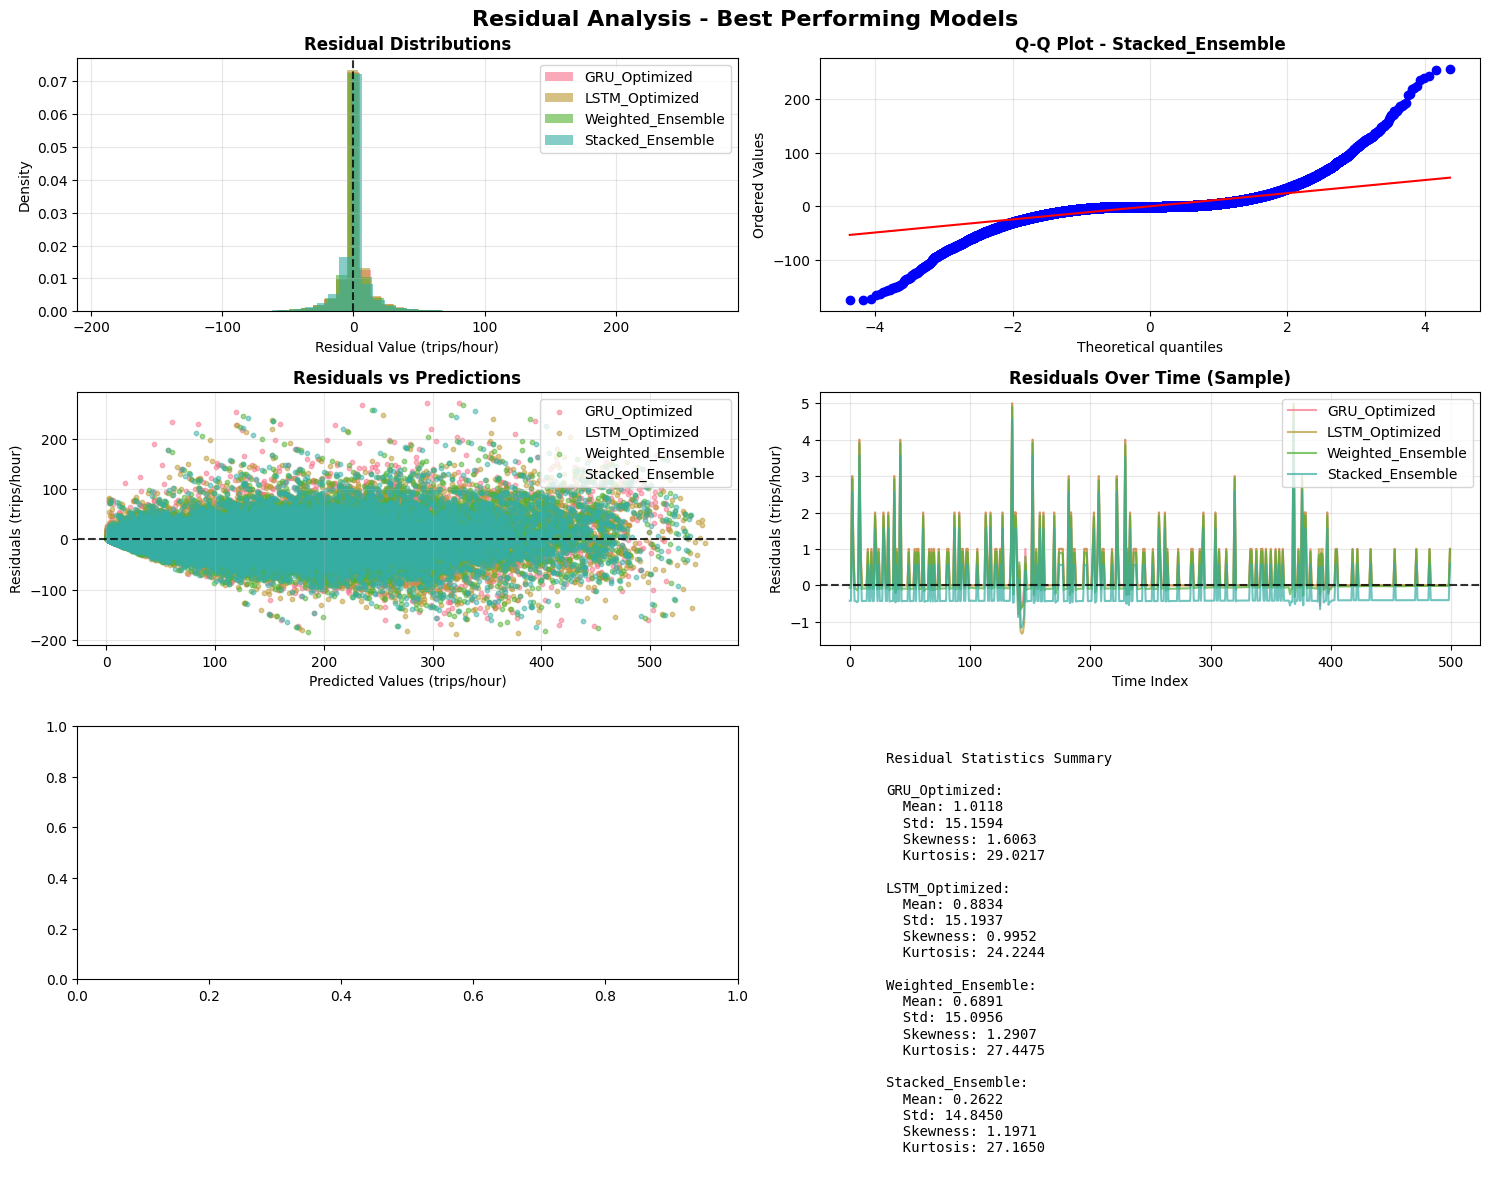

\Residual Insights:
--------------------------------------------------
GRU_Optimized:
  MAE: 7.034 | RMSE: 15.193
  Mean Bias: +1.0118
LSTM_Optimized:
  MAE: 7.084 | RMSE: 15.219
  Mean Bias: +0.8834
Weighted_Ensemble:
  MAE: 7.004 | RMSE: 15.111
  Mean Bias: +0.6891
Stacked_Ensemble:
  MAE: 6.959 | RMSE: 14.847
  Mean Bias: +0.2622


In [ ]:
# Create subplots for residual analysis
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
fig.suptitle('Residual Analysis - Best Performing Models', fontsize=16, fontweight='bold')

# Select key models for detailed analysis
key_models = ['GRU_Optimized', 'LSTM_Optimized', 'Weighted_Ensemble', 'Stacked_Ensemble']

# Residual Distribution (Histograms)
axes[0, 0].set_title('Residual Distributions', fontweight='bold')
for name in key_models:
    axes[0, 0].hist(residuals[name], alpha=0.6, bins=50, label=name, density=True)
axes[0, 0].axvline(0, color='black', linestyle='--', alpha=0.8)
axes[0, 0].set_xlabel('Residual Value (trips/hour)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Q-Q Plot for Normality Check (Best Model)
best_model_name = min(key_models, key=lambda x: np.mean(np.abs(residuals[x])))
stats.probplot(residuals[best_model_name], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title(f'Q-Q Plot - {best_model_name}', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Residuals vs Predictions (Heteroscedasticity Check)
axes[1, 0].set_title('Residuals vs Predictions', fontweight='bold')
for name in key_models:
    axes[1, 0].scatter(model_predictions[name], residuals[name], alpha=0.5, s=10, label=name)
axes[1, 0].axhline(0, color='black', linestyle='--', alpha=0.8)
axes[1, 0].set_xlabel('Predicted Values (trips/hour)')
axes[1, 0].set_ylabel('Residuals (trips/hour)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Residuals Over Time 
axes[1, 1].set_title('Residuals Over Time (Sample)', fontweight='bold')
time_range = range(min(500, len(residuals[best_model_name])))
for name in key_models:
    axes[1, 1].plot(time_range, residuals[name][:len(time_range)], alpha=0.7, label=name)
axes[1, 1].axhline(0, color='black', linestyle='--', alpha=0.8)
axes[1, 1].set_xlabel('Time Index')
axes[1, 1].set_ylabel('Residuals (trips/hour)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Residual Statistics Summary
axes[2, 1].axis('off')
stats_text = "Residual Statistics Summary\n\n"
for name in key_models:
    res = residuals[name]
    mean_res = np.mean(res)
    std_res = np.std(res)
    skewness = stats.skew(res)
    kurtosis = stats.kurtosis(res)
    stats_text += f"{name}:\n"
    stats_text += f"  Mean: {mean_res:.4f}\n"
    stats_text += f"  Std: {std_res:.4f}\n"
    stats_text += f"  Skewness: {skewness:.4f}\n"
    stats_text += f"  Kurtosis: {kurtosis:.4f}\n\n"

axes[2, 1].text(0.1, 0.9, stats_text, transform=axes[2, 1].transAxes, 
                fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

# Print key insights
print("\Residual Insights:")
print("-" * 50)
for name in key_models:
    res = residuals[name]
    mae = np.mean(np.abs(res))
    rmse = np.sqrt(np.mean(res**2))
    print(f"{name}:")
    print(f"  MAE: {mae:.3f} | RMSE: {rmse:.3f}")
    print(f"  Mean Bias: {np.mean(res):+.4f}")

### **Feature Importance Analysis** ###

Analyze which features are most important for the RandomForest baseline model and understand the key drivers of taxi demand predictions.

Using generic feature names (found 1032 features)


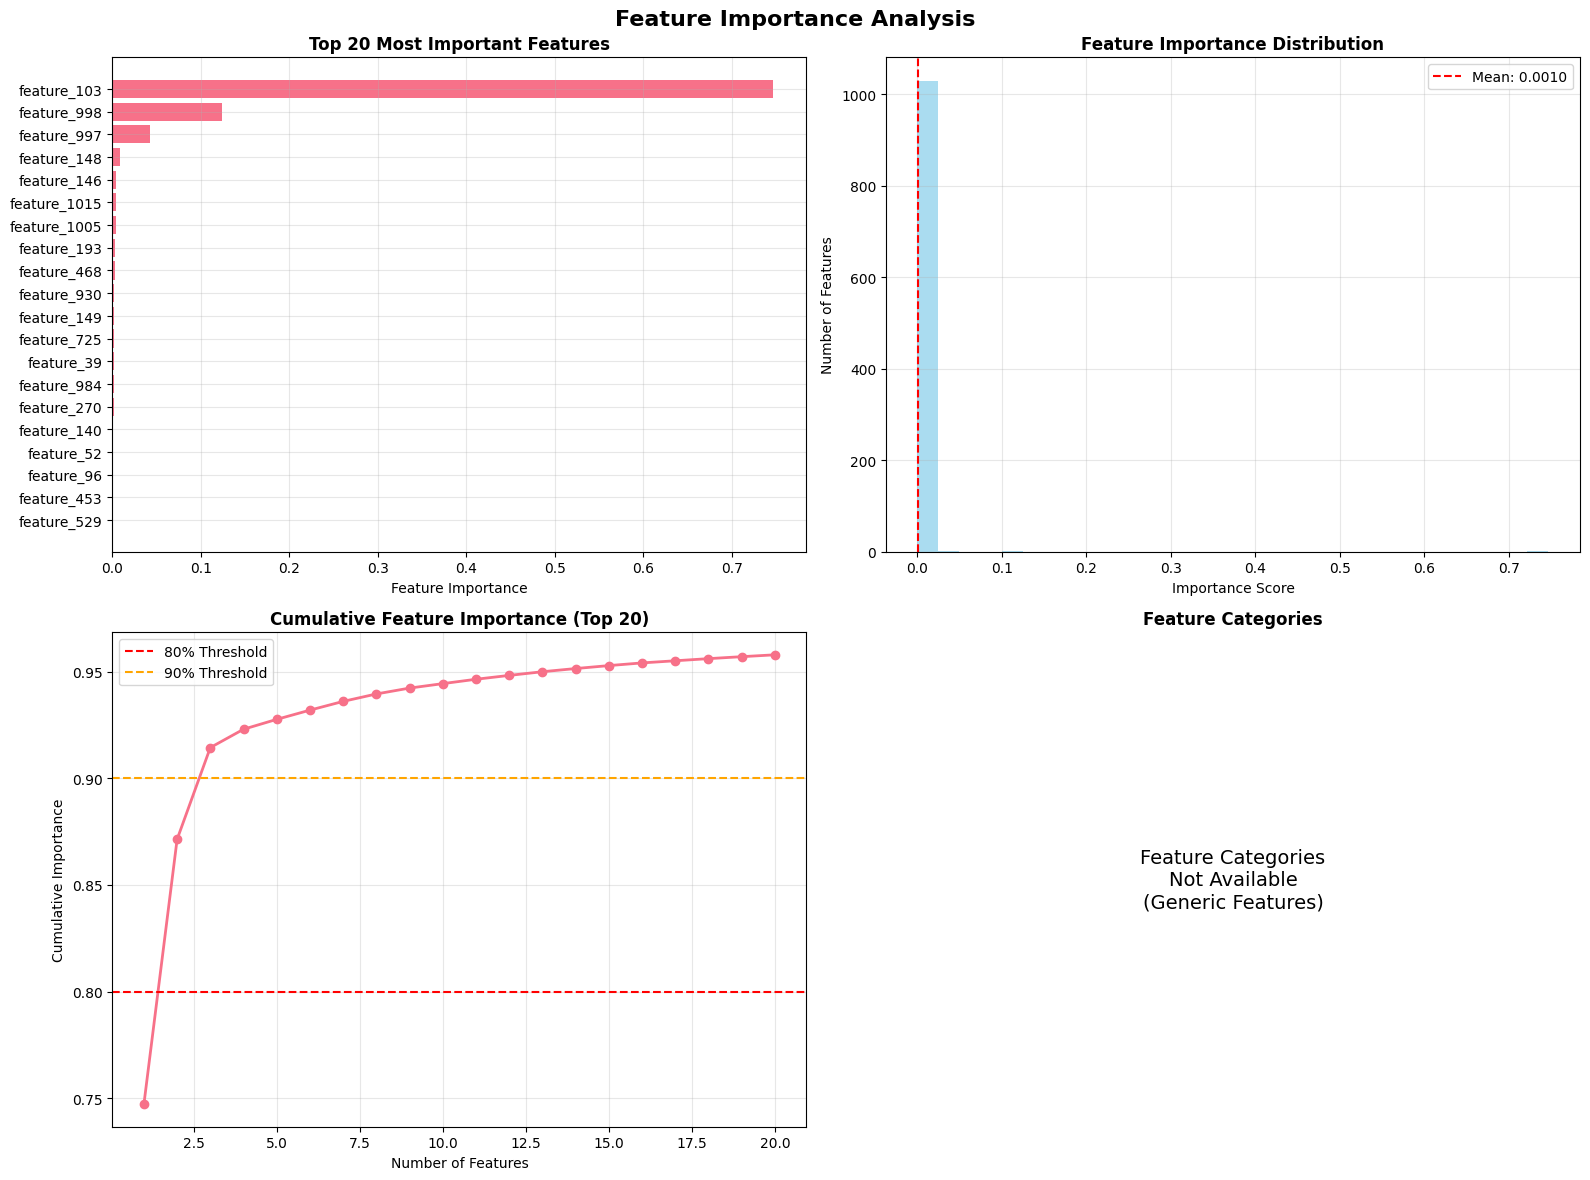


Top 10 most important features:
----------------------------------------
feature_103              : 0.7472
feature_998              : 0.1242
feature_997              : 0.0430
feature_148              : 0.0086
feature_146              : 0.0046
feature_1015             : 0.0043
feature_1005             : 0.0041
feature_193              : 0.0035
feature_468              : 0.0028
feature_930              : 0.0021


In [50]:
# Get feature names
rf_model = best_models['RandomForest_Baseline']
n_features = rf_model.n_features_in_
feature_names = [f'feature_{i}' for i in range(n_features)]
print(f"Using generic feature names (found {n_features} features)")

# Get feature importance
feature_importance = rf_model.feature_importances_

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot feature importance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# Top 20 features bar plot
top_features = importance_df.head(20)
axes[0, 0].barh(top_features['feature'], top_features['importance'])
axes[0, 0].set_title('Top 20 Most Important Features', fontweight='bold')
axes[0, 0].set_xlabel('Feature Importance')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3)

# Feature importance distribution
axes[0, 1].hist(importance_df['importance'], bins=30, alpha=0.7, color='skyblue')
axes[0, 1].set_title('Feature Importance Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Importance Score')
axes[0, 1].set_ylabel('Number of Features')
axes[0, 1].axvline(importance_df['importance'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {importance_df["importance"].mean():.4f}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Cumulative importance
cumulative_importance = np.cumsum(top_features['importance'])
axes[1, 0].plot(range(1, len(cumulative_importance)+1), cumulative_importance, 'o-', linewidth=2)
axes[1, 0].set_title('Cumulative Feature Importance (Top 20)', fontweight='bold')
axes[1, 0].set_xlabel('Number of Features')
axes[1, 0].set_ylabel('Cumulative Importance')
axes[1, 0].axhline(0.8, color='red', linestyle='--', label='80% Threshold')
axes[1, 0].axhline(0.9, color='orange', linestyle='--', label='90% Threshold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Skip pie chart for generic features
axes[1, 1].axis('off')
axes[1, 1].text(0.5, 0.5, 'Feature Categories\nNot Available\n(Generic Features)', 
                ha='center', va='center', fontsize=14, 
                transform=axes[1, 1].transAxes)
axes[1, 1].set_title('Feature Categories', fontweight='bold')

plt.tight_layout()
plt.show()

# Print top features
print(f"\nTop 10 most important features:")
print("-" * 40)
for i, row in importance_df.head(10).iterrows():
    print(f"{row['feature']:25s}: {row['importance']:.4f}")

### **Time Series Decomposition of Errors** ###

Decompose prediction errors into trend, seasonal, and residual components to understand systematic patterns in model performance across different time periods.

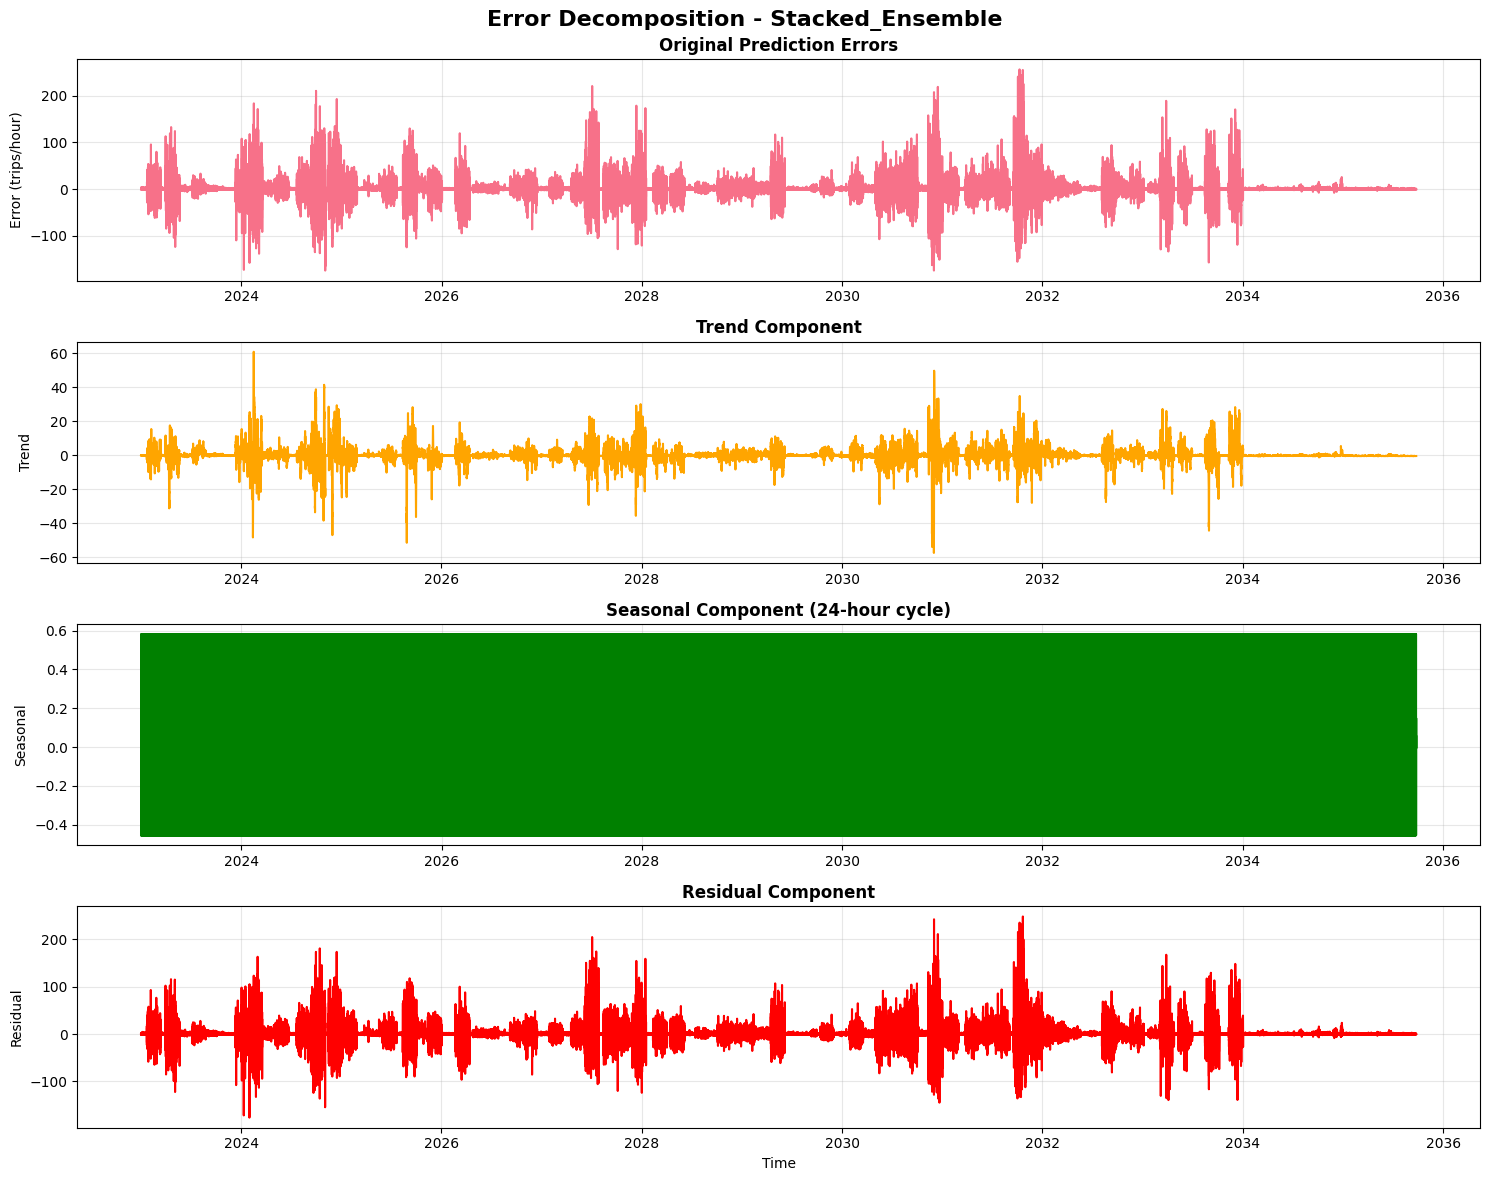

\Error Component Analysis:
Trend Variance:    26.0164 (11.9%)
Seasonal Variance: 0.0550 (0.0%)
Residual Variance: 192.1183 (88.1%)
Total Variance:    218.1897


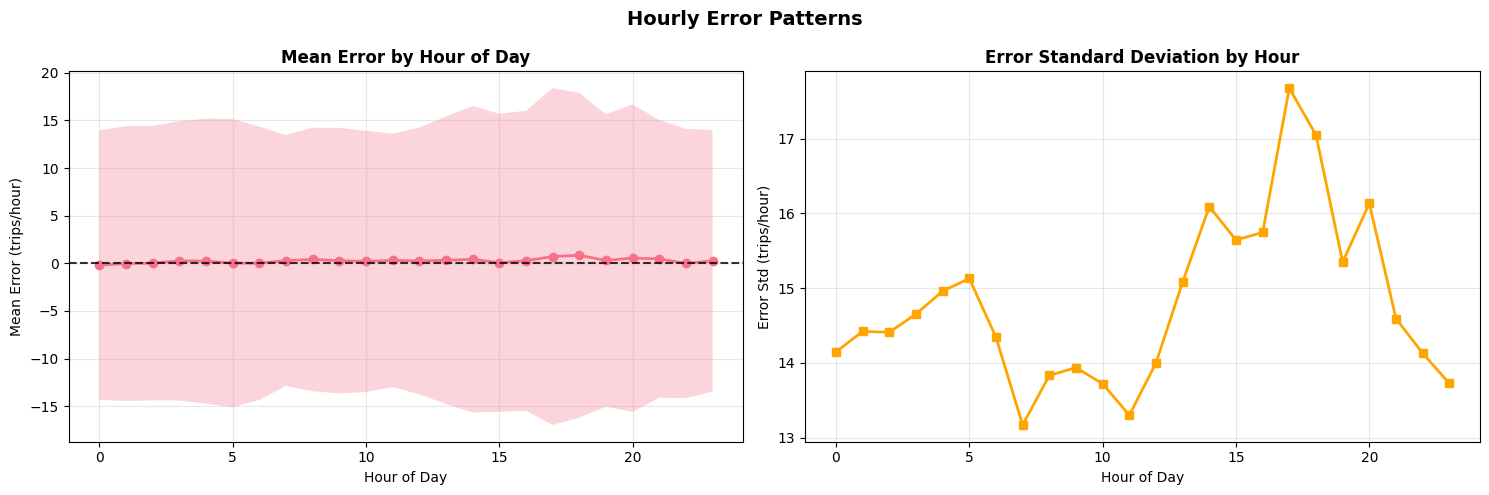

In [ ]:
# Create time series of errors for decomposition
best_ensemble_residuals = residuals[best_ensemble]

# Create a proper time series (assuming hourly data)
min_periods = 48 * 7  # 1 week of hourly data
if len(best_ensemble_residuals) >= min_periods:
    
    # Create time index (assuming hourly frequency)
    time_index = pd.date_range(start='2023-01-01', periods=len(best_ensemble_residuals), freq='H')
    error_series = pd.Series(best_ensemble_residuals, index=time_index)
    
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(error_series, model='additive', period=24)  # Daily seasonality
    
    # Plot decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 12))
    fig.suptitle(f'Error Decomposition - {best_ensemble}', fontsize=16, fontweight='bold')
    
    # Original errors
    axes[0].plot(decomposition.observed)
    axes[0].set_title('Original Prediction Errors', fontweight='bold')
    axes[0].set_ylabel('Error (trips/hour)')
    axes[0].grid(True, alpha=0.3)
    
    # Trend component
    axes[1].plot(decomposition.trend, color='orange')
    axes[1].set_title('Trend Component', fontweight='bold')
    axes[1].set_ylabel('Trend')
    axes[1].grid(True, alpha=0.3)
    
    # Seasonal component
    axes[2].plot(decomposition.seasonal, color='green')
    axes[2].set_title('Seasonal Component (24-hour cycle)', fontweight='bold')
    axes[2].set_ylabel('Seasonal')
    axes[2].grid(True, alpha=0.3)
    
    # Residual component
    axes[3].plot(decomposition.resid, color='red')
    axes[3].set_title('Residual Component', fontweight='bold')
    axes[3].set_ylabel('Residual')
    axes[3].set_xlabel('Time')
    axes[3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate component statistics
    trend_var = np.var(decomposition.trend.dropna())
    seasonal_var = np.var(decomposition.seasonal.dropna())
    residual_var = np.var(decomposition.resid.dropna())
    total_var = trend_var + seasonal_var + residual_var
    
    print(f"\Error Component Analysis:")
    print(f"Trend Variance:    {trend_var:.4f} ({trend_var/total_var*100:.1f}%)")
    print(f"Seasonal Variance: {seasonal_var:.4f} ({seasonal_var/total_var*100:.1f}%)")
    print(f"Residual Variance: {residual_var:.4f} ({residual_var/total_var*100:.1f}%)")
    print(f"Total Variance:    {total_var:.4f}")
    
else:
    print(f"Insufficient data for decomposition (need >{min_periods}, have {len(best_ensemble_residuals)})")
    print("Skipping time series decomposition.")

# Hourly error pattern analysis
hourly_errors = pd.DataFrame({
    'hour': [i % 24 for i in range(len(best_ensemble_residuals))],
    'error': best_ensemble_residuals
})

hourly_stats = hourly_errors.groupby('hour')['error'].agg(['mean', 'std', 'count']).reset_index()

# Plot hourly error patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Hourly Error Patterns', fontsize=14, fontweight='bold')

ax1.plot(hourly_stats['hour'], hourly_stats['mean'], 'o-', linewidth=2, markersize=6)
ax1.fill_between(hourly_stats['hour'], 
                 hourly_stats['mean'] - hourly_stats['std'],
                 hourly_stats['mean'] + hourly_stats['std'], 
                 alpha=0.3)
ax1.set_title('Mean Error by Hour of Day', fontweight='bold')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Mean Error (trips/hour)')
ax1.axhline(0, color='black', linestyle='--', alpha=0.8)
ax1.grid(True, alpha=0.3)

ax2.plot(hourly_stats['hour'], hourly_stats['std'], 's-', linewidth=2, markersize=6, color='orange')
ax2.set_title('Error Standard Deviation by Hour', fontweight='bold')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Error Std (trips/hour)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### **Performance Comparison Visualization** ###

Create comprehensive visualizations comparing all model performances, including individual models, ensembles, and baseline comparisons.

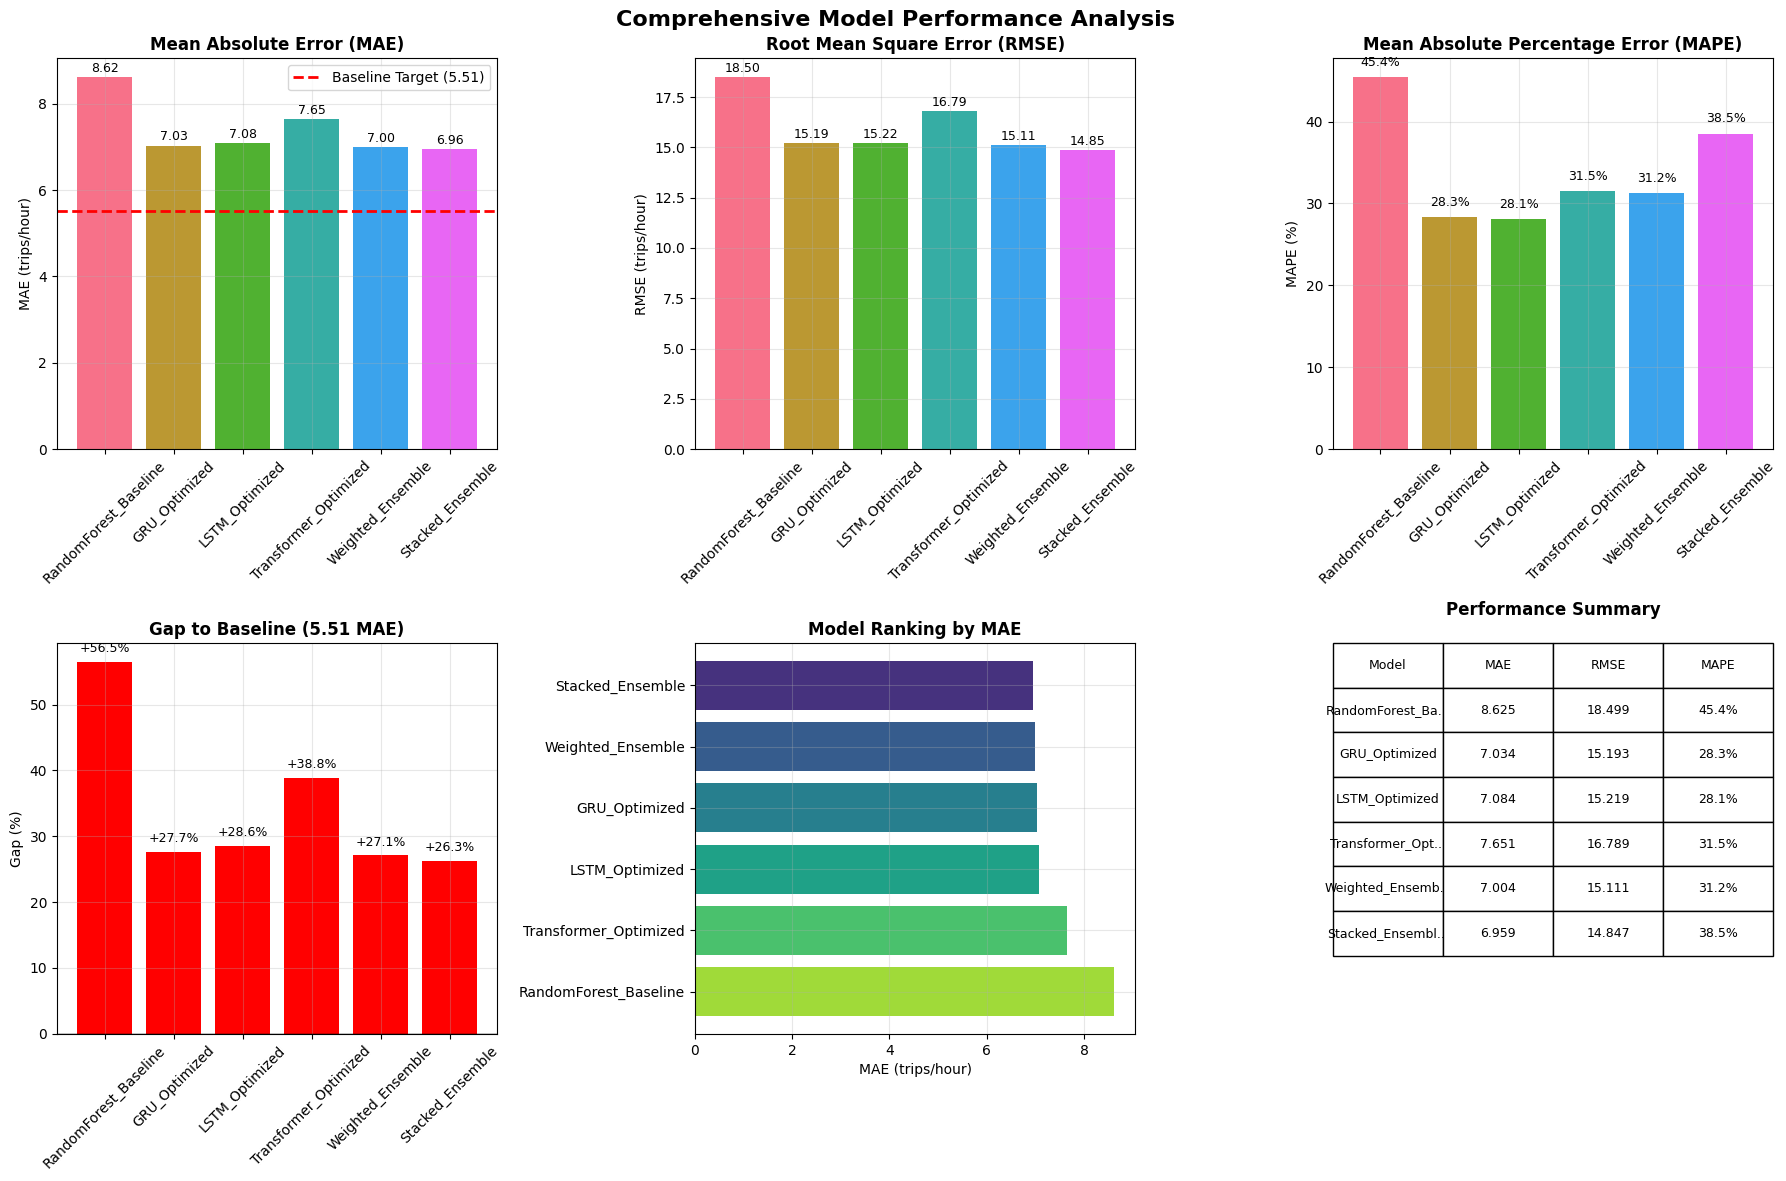

\Detailed Performance Comparision:
Model                MAE      RMSE     MAPE     Gap to Baseline
----------------------------------------------------------------------
Stacked_Ensemble     6.959    14.847   38.5   % +26.3%
Weighted_Ensemble    7.004    15.111   31.2   % +27.1%
GRU_Optimized        7.034    15.193   28.3   % +27.7%
LSTM_Optimized       7.084    15.219   28.1   % +28.6%
Transformer_Optimized 7.651    16.789   31.5   % +38.8%
RandomForest_Baseline 8.625    18.499   45.4   % +56.5%


In [52]:
# Calculate comprehensive metrics for all models
model_metrics = {}
for name, pred in model_predictions.items():
    mae = np.mean(np.abs(sequence_data['y_test'] - pred))
    rmse = np.sqrt(np.mean((sequence_data['y_test'] - pred)**2))
    mape = np.mean(np.abs((sequence_data['y_test'] - pred) / np.maximum(sequence_data['y_test'], 1))) * 100
    
    model_metrics[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'Gap_to_Baseline': ((mae - 5.51) / 5.51) * 100
    }

# Create comprehensive comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comprehensive Model Performance Analysis', fontsize=16, fontweight='bold')

# 1. MAE Comparison
model_names = list(model_metrics.keys())
mae_values = [model_metrics[name]['MAE'] for name in model_names]

bars1 = axes[0, 0].bar(model_names, mae_values, color=sns.color_palette("husl", len(model_names)))
axes[0, 0].axhline(5.51, color='red', linestyle='--', linewidth=2, label='Baseline Target (5.51)')
axes[0, 0].set_title('Mean Absolute Error (MAE)', fontweight='bold')
axes[0, 0].set_ylabel('MAE (trips/hour)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars1, mae_values):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.05,
                    f'{value:.2f}', ha='center', va='bottom', fontsize=9)

# 2. RMSE Comparison
rmse_values = [model_metrics[name]['RMSE'] for name in model_names]
bars2 = axes[0, 1].bar(model_names, rmse_values, color=sns.color_palette("husl", len(model_names)))
axes[0, 1].set_title('Root Mean Square Error (RMSE)', fontweight='bold')
axes[0, 1].set_ylabel('RMSE (trips/hour)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

for bar, value in zip(bars2, rmse_values):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{value:.2f}', ha='center', va='bottom', fontsize=9)

# 3. MAPE Comparison
mape_values = [model_metrics[name]['MAPE'] for name in model_names]
bars3 = axes[0, 2].bar(model_names, mape_values, color=sns.color_palette("husl", len(model_names)))
axes[0, 2].set_title('Mean Absolute Percentage Error (MAPE)', fontweight='bold')
axes[0, 2].set_ylabel('MAPE (%)')
axes[0, 2].tick_params(axis='x', rotation=45)
axes[0, 2].grid(True, alpha=0.3)

for bar, value in zip(bars3, mape_values):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontsize=9)

# 4. Gap to Baseline
gap_values = [model_metrics[name]['Gap_to_Baseline'] for name in model_names]
colors = ['green' if gap < 0 else 'orange' if gap < 20 else 'red' for gap in gap_values]
bars4 = axes[1, 0].bar(model_names, gap_values, color=colors)
axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=1)
axes[1, 0].set_title('Gap to Baseline (5.51 MAE)', fontweight='bold')
axes[1, 0].set_ylabel('Gap (%)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

for bar, value in zip(bars4, gap_values):
    height = bar.get_height()
    y_pos = height + (1 if height >= 0 else -2)
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., y_pos,
                    f'{value:+.1f}%', ha='center', va='bottom' if height >= 0 else 'top', fontsize=9)

# 5. Model Ranking
ranking_df = pd.DataFrame.from_dict(model_metrics, orient='index').sort_values('MAE')
y_pos = np.arange(len(ranking_df))
axes[1, 1].barh(y_pos, ranking_df['MAE'], color=sns.color_palette("viridis", len(ranking_df)))
axes[1, 1].set_yticks(y_pos)
axes[1, 1].set_yticklabels(ranking_df.index)
axes[1, 1].set_title('Model Ranking by MAE', fontweight='bold')
axes[1, 1].set_xlabel('MAE (trips/hour)')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

# 6. Performance Summary Table
axes[1, 2].axis('off')
table_data = []
for name in model_names:
    metrics = model_metrics[name]
    table_data.append([
        name[:15] + '...' if len(name) > 15 else name,
        f"{metrics['MAE']:.3f}",
        f"{metrics['RMSE']:.3f}",
        f"{metrics['MAPE']:.1f}%"
    ])

table = axes[1, 2].table(cellText=table_data,
                        colLabels=['Model', 'MAE', 'RMSE', 'MAPE'],
                        cellLoc='center',
                        loc='center',
                        bbox=[0, 0.2, 1, 0.8])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)
axes[1, 2].set_title('Performance Summary', fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

# Print detailed comparison
print(f"\Detailed Performance Comparision:")
print(f"{'Model':<20} {'MAE':<8} {'RMSE':<8} {'MAPE':<8} {'Gap to Baseline'}")
print("-"*70)
for name in sorted(model_metrics.keys(), key=lambda x: model_metrics[x]['MAE']):
    metrics = model_metrics[name]
    print(f"{name:<20} {metrics['MAE']:<8.3f} {metrics['RMSE']:<8.3f} {metrics['MAPE']:<7.1f}% {metrics['Gap_to_Baseline']:+.1f}%")

### **Ensemble Weight Visualization** ###

Visualize how much each model contributes to the ensemble predictions and understand the ensemble decision-making process.

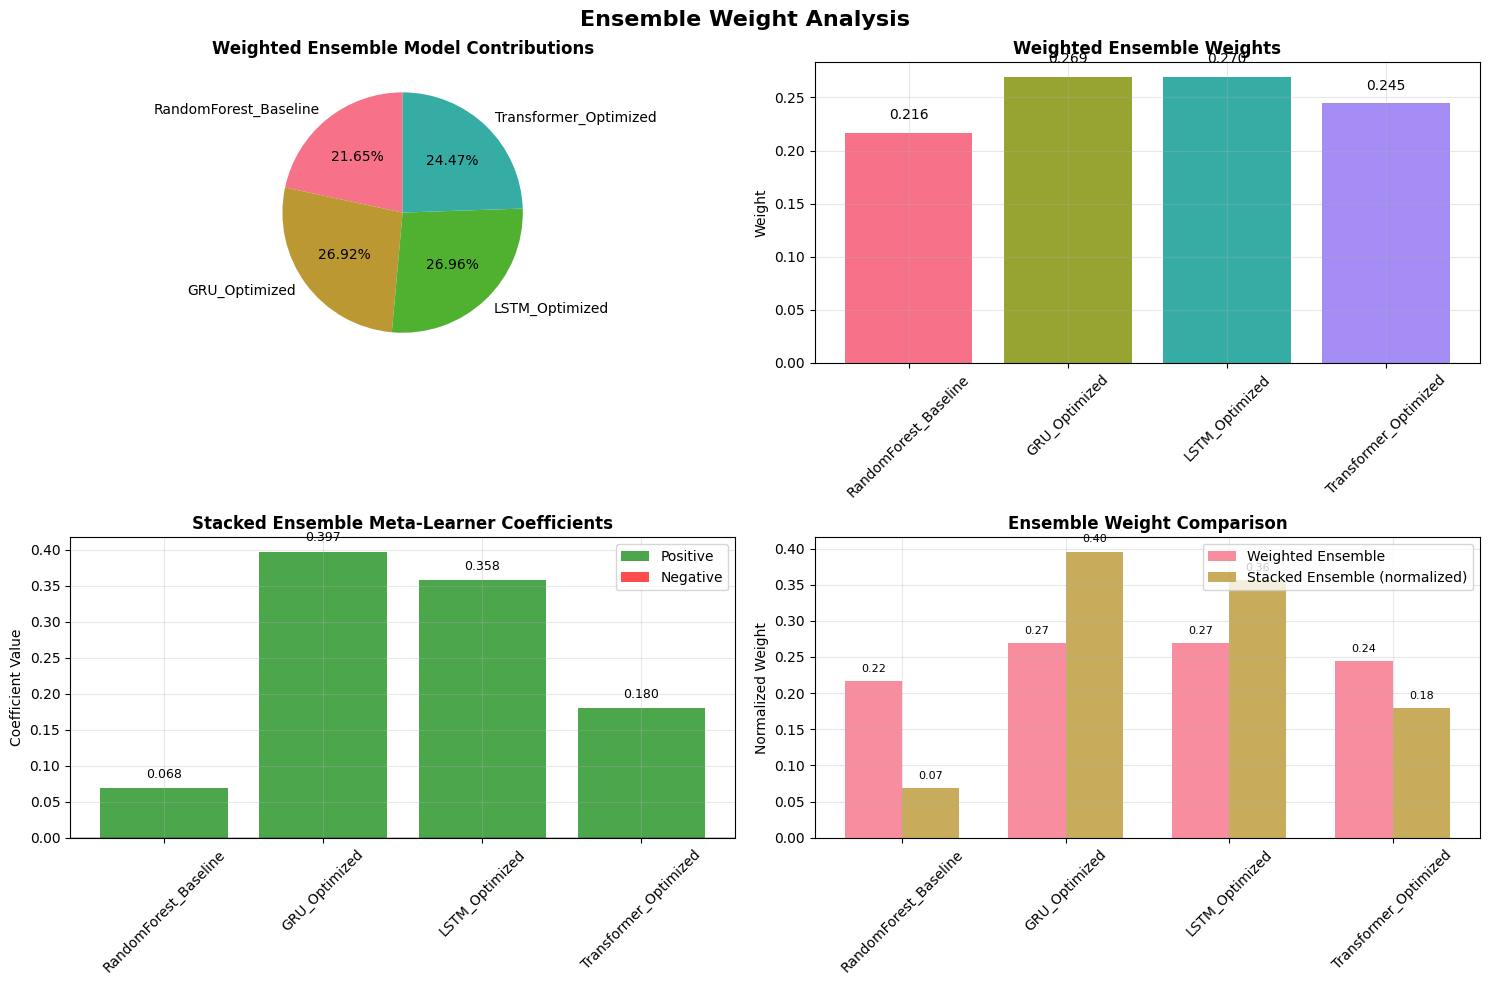

\Ensemble Weight Analysis:
--------------------------------------------------
Weighted Ensemble:
  RandomForest_Baseline    : 0.2165 (21.65%)
  GRU_Optimized            : 0.2692 (26.92%)
  LSTM_Optimized           : 0.2696 (26.96%)
  Transformer_Optimized    : 0.2447 (24.47%)
\Stacked Ensemble Meta-Learner:
  Intercept: 0.3992
  RandomForest_Baseline    : 0.0685
  GRU_Optimized            : 0.3971
  LSTM_Optimized           : 0.3580
  Transformer_Optimized    : 0.1802
\Stacked Ensemble Effective Weights:
  RandomForest_Baseline    : 0.0682 (6.82%)
  GRU_Optimized            : 0.3957 (39.57%)
  LSTM_Optimized           : 0.3566 (35.66%)
  Transformer_Optimized    : 0.1795 (17.95%)


In [53]:
# Create ensemble weight visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Ensemble Weight Analysis', fontsize=16, fontweight='bold')

# 1. Weighted Ensemble Weights (from Phase 5)
if 'weights' in locals():
    model_names_base = list(best_models.keys())
    
    # Pie chart of weighted ensemble
    axes[0, 0].pie(weights, labels=model_names_base, autopct='%1.2f%%', startangle=90)
    axes[0, 0].set_title('Weighted Ensemble Model Contributions', fontweight='bold')

    # Bar chart of weights
    bars = axes[0, 1].bar(model_names_base, weights, color=sns.color_palette("husl", len(model_names_base)))
    axes[0, 1].set_title('Weighted Ensemble Weights', fontweight='bold')
    axes[0, 1].set_ylabel('Weight')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, weight in zip(bars, weights):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{weight:.3f}', ha='center', va='bottom', fontsize=10)

# 2. Stacked Ensemble Meta-Learner Coefficients
if 'meta_learner' in locals():
    coefficients = meta_learner.coef_
    
    # Handle negative coefficients for visualization
    pos_coef = np.maximum(coefficients, 0)
    neg_coef = np.minimum(coefficients, 0)
    
    x_pos = np.arange(len(model_names_base))
    axes[1, 0].bar(x_pos, pos_coef, label='Positive', color='green', alpha=0.7)
    axes[1, 0].bar(x_pos, neg_coef, label='Negative', color='red', alpha=0.7)
    axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=1)
    axes[1, 0].set_title('Stacked Ensemble Meta-Learner Coefficients', fontweight='bold')
    axes[1, 0].set_ylabel('Coefficient Value')
    axes[1, 0].set_xticks(x_pos)
    axes[1, 0].set_xticklabels(model_names_base, rotation=45)
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Add value labels
    for i, (pos, neg) in enumerate(zip(pos_coef, neg_coef)):
        if pos > 0:
            axes[1, 0].text(i, pos + 0.01, f'{coefficients[i]:.3f}', ha='center', va='bottom', fontsize=9)
        if neg < 0:
            axes[1, 0].text(i, neg - 0.01, f'{coefficients[i]:.3f}', ha='center', va='top', fontsize=9)

# 3. Weight Comparison Between Ensembles
if 'weights' in locals() and 'meta_learner' in locals():
    # Normalize meta-learner coefficients for comparison
    normalized_coef = np.abs(coefficients) / np.sum(np.abs(coefficients))
    
    x = np.arange(len(model_names_base))
    width = 0.35
    
    bars1 = axes[1, 1].bar(x - width/2, weights, width, label='Weighted Ensemble', alpha=0.8)
    bars2 = axes[1, 1].bar(x + width/2, normalized_coef, width, label='Stacked Ensemble (normalized)', alpha=0.8)
    
    axes[1, 1].set_title('Ensemble Weight Comparison', fontweight='bold')
    axes[1, 1].set_ylabel('Normalized Weight')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(model_names_base, rotation=45)
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, weight in zip(bars1, weights):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{weight:.2f}', ha='center', va='bottom', fontsize=8)
    
    for bar, weight in zip(bars2, normalized_coef):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                        f'{weight:.2f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

# Print ensemble weight analysis
print(f"\Ensemble Weight Analysis:")
print("-"*50)

if 'weights' in locals():
    print("Weighted Ensemble:")
    for name, weight in zip(model_names_base, weights):
        print(f"  {name:<25}: {weight:.4f} ({weight*100:.2f}%)")

if 'meta_learner' in locals():
    print(f"\Stacked Ensemble Meta-Learner:")
    print(f"  Intercept: {meta_learner.intercept_:.4f}")
    for name, coef in zip(model_names_base, coefficients):
        print(f"  {name:<25}: {coef:.4f}")
    
    # Calculate effective weights (absolute values normalized)
    effective_weights = np.abs(coefficients) / np.sum(np.abs(coefficients))
    print(f"\Stacked Ensemble Effective Weights:")
    for name, weight in zip(model_names_base, effective_weights):
        print(f"  {name:<25}: {weight:.4f} ({weight*100:.2f}%)")